# AI6126 ACV Project 1


In [40]:
nb_ver = 0.4
title = f'ai6126-project1-colab-v{nb_ver}'
print(title)
comments = ""
print(comments)

ai6126-project1-colab-v0.4


## Versioning & References

### Changelogs
+ V0.1 - Setup codes to download and unzip celeba to gDrive
+ V0.2 - Added training loop 
+ V0.3 - Added seeding + save/ load checkpoint
+ V0.4 - Added time taken + save output

### References
+ [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
+ [TWD fast.ai](https://towardsdatascience.com/real-time-multi-facial-attribute-detection-using-transfer-learning-and-haar-cascades-with-fastai-47ff59e36df0)

## Setup/ Configuration

### Colab

In [2]:
# you can choose to mount your Google Drive (optional)
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    file_name = f'ai6126-project1-colab-v{nb_ver}.ipynb'
    print(file_name)
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

In [3]:
# check nvcc version
!nvcc -V
# check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:32:27_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.2, V10.2.89


'gcc' is not recognized as an internal or external command,
operable program or batch file.


### Download Dataset

In [4]:
import os, glob
local_download_path = '../data/celeba/img_align_celeba'
download_dataset = True
if os.path.exists(local_download_path):
    images = glob.glob(local_download_path + '/*.jpg')
    if len(images) == 202599:
        download_dataset = False
print(f"download celeba dataset: {download_dataset}")

if download_dataset:
    # create dataset root and enter it
    !mkdir -p data/celeba
    %cd data/celeba

    # we have prepared a backup of `img_align_celeba.zip` of Celeb-A dataset in the Dropbox
    # download it directly, or manually download the original file from Google Drive above
    !wget https://www.dropbox.com/s/8kzo40fqx7nodat/img_align_celeba.zip

    # unzip the downloaded file
    !unzip -qq img_align_celeba.zip
    !rm -f img_align_celeba.zip

    # change the directory back to the root
    %cd ../..
    !ls

download celeba dataset: False


## Implementation

### Imports

In [1]:
import os
import time
import random
import numpy as np
import copy
from datetime import datetime
from distutils.dir_util import copy_tree #for recursive filecopying

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import matplotlib.pyplot as plt

import config
from celeba_dataset import CelebaDataset
import models
from utils import Logger, AverageMeter, Bar, savefig, adjust_learning_rate, accuracy, reset_gpu_cache, print_attribute_acc, create_dir_ifne

In [6]:
# set the backend of matplotlib to the 'inline' backend
%matplotlib inline

# check PyTorch version and cuda status
print(torch.__version__, torch.cuda.is_available())

# define device
device = torch.device("cuda:"+config.gpu_id if torch.cuda.is_available() else "cpu")
print(device)

if 'ipykernel' in sys.modules:
    config.disable_tqdm = False
print(f"disable_tqdm: {config.disable_tqdm}")

1.6.0 True
cuda:0
disable_tqdm: False


### Seeding

In [7]:
# set random seed for reproducibility
def seed_everything(seed=None):
    if seed is None:
        seed = random.randint(1, 10000) # create random seed
        print(f'random seed used: {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    if 'torch' in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config.manual_seed)

### Data Transform

In [8]:
# attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
#                    'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
#                    'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
#                    'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
#                    'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
#                    'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
#                    'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
# print(attribute_names)

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation and testing

def load_dataloaders(print_info=True):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    if config.evaluate:
        phases = ['test']
    else:
        phases = ['train', 'val']

    attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
    
    attributes_list = {
        'train': config.TRAIN_ATTRIBUTE_LIST,
        'val': config.VAL_ATTRIBUTE_LIST,
        'test': config.TEST_ATTRIBUTE_LIST
    }

    batch_sizes = {
        'train': config.train_batch,
        'val': config.test_batch,
        'test': config.test_batch
    }

    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            normalize
        ]),
        'val': transforms.Compose([
            transforms.ToTensor(),
            normalize
        ]),
        'test': transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])
    }

    image_datasets = {x: CelebaDataset(config.IMG_DIR, attributes_list[x], 
                                       data_transforms[x]) 
                      for x in phases}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=batch_sizes[x],
                                                  pin_memory=True, shuffle=(x == 'train'), 
                                                  num_workers=config.dl_workers) 
                   for x in phases}
    if print_info:
        dataset_sizes = {x: len(image_datasets[x]) for x in phases}
        print(f"Dataset sizes: {dataset_sizes}")
        
    if config.evaluate:
        class_names = image_datasets['test'].targets
    else:
        class_names = image_datasets['train'].targets
    print(f"Class Labels: {len(class_names[0])}")
    assert len(attribute_names) == len(class_names[0])
    return dataloaders, attribute_names

### Model Architecture Initialization

In [10]:
model_names = sorted(name for name in models.__dict__
                     if callable(models.__dict__[name])) # and name.islower() and not name.startswith("__"))
print(f"Available Models: {model_names}")

Available Models: ['FaceAttrResNet']


In [11]:
def create_model(device):
    print("=> creating model '{}'".format(config.arch))
    if config.arch.startswith('FaceAttrResNet'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    model = model.to(device)
    return model
#print(model)

### Criterion & Optimizer

In [12]:
# criterion = nn.CrossEntropyLoss().to(device)

# optimizer = torch.optim.SGD(model.parameters(), config.lr,
#                             momentum=config.momentum,
#                             weight_decay=config.weight_decay)

### Resume Checkpoint if any

In [13]:
def resume_checkpoint(model, optimizer, ckp_logger_fname, ckp_resume=None):
    if not os.path.isdir(config.CHECKPOINT_DIR):
        try: 
            os.makedirs(config.CHECKPOINT_DIR)
        except OSError:
            raise
            
    start_epoch = 0
    best_prec1 = 0
    if ckp_resume and os.path.isfile(ckp_resume): 
        print(f"=> resuming model: {ckp_resume}")
        optimizer, start_epoch, best_prec1 = model.load_ckp(optimizer, ckp_resume)
        # print(f"=> loading checkpoint '{config.resume}'")
        # checkpoint = torch.load(config.resume)
        # start_epoch = checkpoint['epoch']
        # best_prec1 = checkpoint['best_prec1']
        # model.load_state_dict(checkpoint['state_dict'])
        # optimizer.load_state_dict(checkpoint['optimizer'])
        # print(f"=> loaded checkpoint '{config.resume}' (epoch {start_epoch})")
        config.checkpoint = os.path.dirname(ckp_resume)
        logger = Logger(ckp_logger_fname, title=model.name, resume=True)
    else:
        logger = Logger(ckp_logger_fname, title=model.name)
        logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])
        
        
    return best_prec1, start_epoch, logger

## Train & Validate Function

In [14]:
def train(train_loader, model, criterion, optimizer):
    bar = Bar('Processing', max=len(train_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to train mode
    model.train()

    end = time.time()
    for i, (X, y) in enumerate(tqdm(train_loader, disable=config.disable_tqdm)):
        # measure data loading time
        data_time.update(time.time() - end)

        # Overlapping transfer if pinned memory
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
    
        # compute output
        output = model(X)
        # measure accuracy and record loss
        loss = []
        prec1 = []
        for j in range(len(output)):
            loss.append(criterion(output[j], y[:, j]))
            prec1.append(accuracy(output[j], y[:, j], topk=(1,)))

            losses[j].update(loss[j].detach().item(), X.size(0))
            top1[j].update(prec1[j][0].item(), X.size(0))
            
        losses_avg = [losses[k].avg for k in range(len(losses))]
        top1_avg = [top1[k].avg for k in range(len(top1))]
        loss_avg = sum(losses_avg) / len(losses_avg)
        prec1_avg = sum(top1_avg) / len(top1_avg)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss_sum = sum(loss)
        loss_sum.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                        batch=i + 1,
                        size=len(train_loader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=loss_avg,
                        top1=prec1_avg,
                        )
        if not config.disable_tqdm and (i+1)% 100 == 0:
            print(print_line)
        bar.suffix  = print_line
        bar.next()
    bar.finish()
    return (loss_avg, prec1_avg)

In [15]:
def validate(val_loader, model, criterion):
    bar = Bar('Processing', max=len(val_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (X, y) in enumerate(tqdm(val_loader, disable=config.disable_tqdm)):
            # measure data loading time
            data_time.update(time.time() - end)

            # Overlapping transfer if pinned memory
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # compute output
            output = model(X)
            # measure accuracy and record loss
            loss = []
            prec1 = []
            for j in range(len(output)):
                loss.append(criterion(output[j], y[:, j]))
                prec1.append(accuracy(output[j], y[:, j], topk=(1,)))

                losses[j].update(loss[j].detach().item(), X.size(0))
                top1[j].update(prec1[j][0].item(), X.size(0))
            losses_avg = [losses[k].avg for k in range(len(losses))]
            top1_avg = [top1[k].avg for k in range(len(top1))]
            loss_avg = sum(losses_avg) / len(losses_avg)
            prec1_avg = sum(top1_avg) / len(top1_avg)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

        # plot progress
        print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                        batch=i + 1,
                        size=len(val_loader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=loss_avg,
                        top1=prec1_avg,
                        )
        if not config.disable_tqdm and (i+1)% 100 == 0:
            print(print_line)
        bar.suffix  = print_line
        bar.next()  
    bar.finish()
    return (loss_avg, prec1_avg, top1)

## Main Function

In [16]:
def trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name):
    # visualization
    writer = SummaryWriter(os.path.join(config.tensorboard_dir, run_name))

    for epoch in range(start_epoch, config.epochs):
        lr = adjust_learning_rate(optimizer, config.lr_decay, epoch, gamma=config.gamma, step=config.step,
                                 total_epochs=config.epochs, turning_point=config.turning_point,
                                 schedule=config.schedule)

        print('\nEpoch: [%d | %d] LR: %f' % (epoch + 1, config.epochs, lr))

        # train for one epoch
        train_loss, train_acc = train(dataloaders['train'], model, criterion, optimizer)

        # evaluate on validation set
        val_loss, prec1, _ = validate(dataloaders['val'], model, criterion)

        # append logger file
        logger.append([lr, train_loss, val_loss, train_acc, prec1])

        # tensorboardX
        writer.add_scalar('learning rate', lr, epoch + 1)
        writer.add_scalars('loss', {'train loss': train_loss, 'validation loss': val_loss}, epoch + 1)
        writer.add_scalars('accuracy', {'train accuracy': train_acc, 'validation accuracy': prec1}, epoch + 1)
        #for name, param in model.named_parameters():
        #    writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch + 1)

        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        model.save_ckp({
            'epoch': epoch + 1,
            'arch': model.name,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict()
        }, is_best, config.checkpoint_fname,config.bestmodel_fname)

    logger.close()
    logger.plot()
    savefig(config.train_plotfig)
    writer.close()

    print('Best accuracy:')
    print(best_prec1)

In [36]:
def get_run_name_time(model, criterion, optimizer, comments):
    if str(criterion) == 'CrossEntropyLoss()':
        p_criterion = 'CE'

    p_optimizer = f'{str(optimizer).split("(")[0].strip()}_'
    p_scheduler = f'{config.lr_decay}_lr{config.lr}_wd{config.weight_decay}'
    if config.lr_decay == 'step':
        p_scheduler += f'_g{config.gamma}_sp{config.step}'
    elif config.lr_decay == 'linear2exp':
        p_scheduler += f'_g{config.gamma}_tp{config.turning_point}'
    elif config.lr_decay == 'schedule':
        p_scheduler += f'_g{config.gamma}_sch{config.schedule}'

    run_name = f'{model.name}_{config.manual_seed}_s{start_epoch}e{config.epochs}_' \
                + f'tb{config.train_batch}_vb{config.test_batch}_' \
                + f'{p_criterion}_{p_optimizer}_' \
                + f'{comments} \
                + f'{p_scheduler}'
    
    run_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    print(run_name, run_time)
    return run_name, run_time

=> creating model 'FaceAttrResNet'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]

Dataset sizes: {'train': 162770, 'val': 19867}
Class Labels: 40
FaceAttrResNet18_42_s0e60_tb128_vb128_CE_SGD__step_lr0.1_wd0.0001_g0.1_sp30

Epoch: [1 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:35<04:52,  4.00it/s]

(100/1272) Data: 0.072s | Batch: 0.354s | Total: 0:00:35 | ETA: 0:04:54 | Loss: 0.6895 | top1:  79.3785


 16%|████████████▍                                                                  | 200/1272 [01:01<04:30,  3.96it/s]

(200/1272) Data: 0.036s | Batch: 0.306s | Total: 0:01:01 | ETA: 0:04:35 | Loss: 0.6516 | top1:  79.7167


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:10,  3.88it/s]

(300/1272) Data: 0.024s | Batch: 0.289s | Total: 0:01:26 | ETA: 0:04:10 | Loss: 0.6153 | top1:  79.9493


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:49,  3.79it/s]

(400/1272) Data: 0.018s | Batch: 0.281s | Total: 0:01:52 | ETA: 0:03:47 | Loss: 0.5932 | top1:  80.0231


 39%|███████████████████████████████                                                | 500/1272 [02:18<03:27,  3.72it/s]

(500/1272) Data: 0.015s | Batch: 0.278s | Total: 0:02:18 | ETA: 0:03:28 | Loss: 0.5702 | top1:  80.1089


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:45<02:58,  3.77it/s]

(600/1272) Data: 0.013s | Batch: 0.276s | Total: 0:02:45 | ETA: 0:03:00 | Loss: 0.5532 | top1:  80.2375


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:30,  3.81it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:36 | Loss: 0.5368 | top1:  80.4077


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:05,  3.76it/s]

(800/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:40 | ETA: 0:02:08 | Loss: 0.5233 | top1:  80.5882


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:38,  3.77it/s]

(900/1272) Data: 0.009s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:40 | Loss: 0.5111 | top1:  80.7796


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:34<01:14,  3.65it/s]

(1000/1272) Data: 0.008s | Batch: 0.275s | Total: 0:04:34 | ETA: 0:01:16 | Loss: 0.4992 | top1:  81.0129


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:01<00:46,  3.67it/s]

(1100/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:01 | ETA: 0:00:48 | Loss: 0.4876 | top1:  81.2590


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:29<00:20,  3.51it/s]

(1200/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:29 | ETA: 0:00:21 | Loss: 0.4770 | top1:  81.5133


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  7.01it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [2 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:33<05:11,  3.76it/s]

(100/1272) Data: 0.074s | Batch: 0.333s | Total: 0:00:33 | ETA: 0:05:14 | Loss: 0.3446 | top1:  85.0574


 16%|████████████▍                                                                  | 200/1272 [01:00<04:54,  3.65it/s]

(200/1272) Data: 0.037s | Batch: 0.301s | Total: 0:01:00 | ETA: 0:04:49 | Loss: 0.3361 | top1:  85.5020


 24%|██████████████████▋                                                            | 300/1272 [01:27<04:20,  3.73it/s]

(300/1272) Data: 0.025s | Batch: 0.291s | Total: 0:01:27 | ETA: 0:04:22 | Loss: 0.3278 | top1:  85.8213


 31%|████████████████████████▊                                                      | 400/1272 [01:54<03:53,  3.73it/s]

(400/1272) Data: 0.019s | Batch: 0.286s | Total: 0:01:54 | ETA: 0:03:51 | Loss: 0.3223 | top1:  86.0471


 39%|███████████████████████████████                                                | 500/1272 [02:21<03:22,  3.81it/s]

(500/1272) Data: 0.015s | Batch: 0.283s | Total: 0:02:21 | ETA: 0:03:27 | Loss: 0.3178 | top1:  86.2169


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:48<03:01,  3.71it/s]

(600/1272) Data: 0.013s | Batch: 0.281s | Total: 0:02:48 | ETA: 0:03:03 | Loss: 0.3134 | top1:  86.3908


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:15<02:38,  3.60it/s]

(700/1272) Data: 0.011s | Batch: 0.280s | Total: 0:03:15 | ETA: 0:02:34 | Loss: 0.3093 | top1:  86.5568


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:42<02:06,  3.74it/s]

(800/1272) Data: 0.010s | Batch: 0.279s | Total: 0:03:42 | ETA: 0:02:08 | Loss: 0.3059 | top1:  86.6863


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:09<01:38,  3.78it/s]

(900/1272) Data: 0.009s | Batch: 0.278s | Total: 0:04:09 | ETA: 0:01:41 | Loss: 0.3026 | top1:  86.8161


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:37<01:13,  3.71it/s]

(1000/1272) Data: 0.008s | Batch: 0.277s | Total: 0:04:37 | ETA: 0:01:16 | Loss: 0.2995 | top1:  86.9405


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:04<00:46,  3.69it/s]

(1100/1272) Data: 0.007s | Batch: 0.277s | Total: 0:05:04 | ETA: 0:00:47 | Loss: 0.2964 | top1:  87.0684


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:31<00:19,  3.70it/s]

(1200/1272) Data: 0.007s | Batch: 0.276s | Total: 0:05:31 | ETA: 0:00:20 | Loss: 0.2939 | top1:  87.1670


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  7.06it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [3 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:33<05:13,  3.74it/s]

(100/1272) Data: 0.073s | Batch: 0.332s | Total: 0:00:33 | ETA: 0:05:14 | Loss: 0.2585 | top1:  88.6285


 16%|████████████▍                                                                  | 200/1272 [01:00<04:52,  3.67it/s]

(200/1272) Data: 0.037s | Batch: 0.302s | Total: 0:01:00 | ETA: 0:04:56 | Loss: 0.2628 | top1:  88.4375


 24%|██████████████████▋                                                            | 300/1272 [01:27<04:22,  3.71it/s]

(300/1272) Data: 0.025s | Batch: 0.291s | Total: 0:01:27 | ETA: 0:04:22 | Loss: 0.2606 | top1:  88.5249


 31%|████████████████████████▊                                                      | 400/1272 [01:54<04:06,  3.54it/s]

(400/1272) Data: 0.019s | Batch: 0.286s | Total: 0:01:54 | ETA: 0:03:58 | Loss: 0.2584 | top1:  88.6081


 39%|███████████████████████████████                                                | 500/1272 [02:21<03:27,  3.72it/s]

(500/1272) Data: 0.015s | Batch: 0.283s | Total: 0:02:21 | ETA: 0:03:28 | Loss: 0.2568 | top1:  88.6761


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:48<02:56,  3.81it/s]

(600/1272) Data: 0.013s | Batch: 0.281s | Total: 0:02:48 | ETA: 0:02:59 | Loss: 0.2549 | top1:  88.7621


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:15<02:32,  3.74it/s]

(700/1272) Data: 0.011s | Batch: 0.279s | Total: 0:03:15 | ETA: 0:02:33 | Loss: 0.2532 | top1:  88.8283


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:42<02:09,  3.65it/s]

(800/1272) Data: 0.010s | Batch: 0.278s | Total: 0:03:42 | ETA: 0:02:09 | Loss: 0.2519 | top1:  88.8783


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:09<01:41,  3.65it/s]

(900/1272) Data: 0.009s | Batch: 0.277s | Total: 0:04:09 | ETA: 0:01:40 | Loss: 0.2505 | top1:  88.9388


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:36<01:12,  3.73it/s]

(1000/1272) Data: 0.008s | Batch: 0.277s | Total: 0:04:36 | ETA: 0:01:15 | Loss: 0.2491 | top1:  88.9972


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:03<00:46,  3.66it/s]

(1100/1272) Data: 0.007s | Batch: 0.276s | Total: 0:05:03 | ETA: 0:00:47 | Loss: 0.2479 | top1:  89.0444


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:30<00:19,  3.66it/s]

(1200/1272) Data: 0.007s | Batch: 0.276s | Total: 0:05:30 | ETA: 0:00:20 | Loss: 0.2468 | top1:  89.0886


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.12it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [4 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:33<05:17,  3.70it/s]

(100/1272) Data: 0.072s | Batch: 0.333s | Total: 0:00:33 | ETA: 0:05:15 | Loss: 0.2331 | top1:  89.6322


 16%|████████████▍                                                                  | 200/1272 [01:00<04:45,  3.75it/s]

(200/1272) Data: 0.036s | Batch: 0.301s | Total: 0:01:00 | ETA: 0:04:49 | Loss: 0.2312 | top1:  89.7237


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:23,  3.69it/s]

(300/1272) Data: 0.025s | Batch: 0.290s | Total: 0:01:26 | ETA: 0:04:21 | Loss: 0.2298 | top1:  89.7958


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:47,  3.83it/s]

(400/1272) Data: 0.019s | Batch: 0.284s | Total: 0:01:53 | ETA: 0:03:56 | Loss: 0.2291 | top1:  89.8364


 39%|███████████████████████████████                                                | 500/1272 [02:20<03:26,  3.74it/s]

(500/1272) Data: 0.015s | Batch: 0.281s | Total: 0:02:20 | ETA: 0:03:28 | Loss: 0.2282 | top1:  89.8717


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:47<03:05,  3.61it/s]

(600/1272) Data: 0.013s | Batch: 0.279s | Total: 0:02:47 | ETA: 0:03:00 | Loss: 0.2277 | top1:  89.9022


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:34,  3.71it/s]

(700/1272) Data: 0.011s | Batch: 0.277s | Total: 0:03:13 | ETA: 0:02:35 | Loss: 0.2274 | top1:  89.9191


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:04,  3.79it/s]

(800/1272) Data: 0.010s | Batch: 0.276s | Total: 0:03:40 | ETA: 0:02:07 | Loss: 0.2271 | top1:  89.9395


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:38,  3.78it/s]

(900/1272) Data: 0.009s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:39 | Loss: 0.2265 | top1:  89.9640


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:34<01:11,  3.78it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:34 | ETA: 0:01:14 | Loss: 0.2259 | top1:  89.9918


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:45,  3.76it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:46 | Loss: 0.2254 | top1:  90.0138


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:19,  3.68it/s]

(1200/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.2249 | top1:  90.0373


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.44it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [5 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:06,  3.83it/s]

(100/1272) Data: 0.069s | Batch: 0.326s | Total: 0:00:32 | ETA: 0:05:06 | Loss: 0.2171 | top1:  90.4109


 16%|████████████▍                                                                  | 200/1272 [00:58<04:40,  3.82it/s]

(200/1272) Data: 0.035s | Batch: 0.295s | Total: 0:00:58 | ETA: 0:04:46 | Loss: 0.2177 | top1:  90.3692


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:18,  3.75it/s]

(300/1272) Data: 0.023s | Batch: 0.285s | Total: 0:01:25 | ETA: 0:04:21 | Loss: 0.2170 | top1:  90.3891


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:56,  3.69it/s]

(400/1272) Data: 0.018s | Batch: 0.280s | Total: 0:01:52 | ETA: 0:03:50 | Loss: 0.2167 | top1:  90.4063


 39%|███████████████████████████████                                                | 500/1272 [02:18<03:21,  3.83it/s]

(500/1272) Data: 0.014s | Batch: 0.278s | Total: 0:02:18 | ETA: 0:03:23 | Loss: 0.2163 | top1:  90.4301


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:45<02:52,  3.89it/s]

(600/1272) Data: 0.012s | Batch: 0.276s | Total: 0:02:45 | ETA: 0:02:56 | Loss: 0.2157 | top1:  90.4507


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:12<02:28,  3.85it/s]

(700/1272) Data: 0.010s | Batch: 0.274s | Total: 0:03:12 | ETA: 0:02:31 | Loss: 0.2152 | top1:  90.4708


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:38<02:05,  3.76it/s]

(800/1272) Data: 0.009s | Batch: 0.274s | Total: 0:03:38 | ETA: 0:02:07 | Loss: 0.2149 | top1:  90.4831


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:05<01:36,  3.84it/s]

(900/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:05 | ETA: 0:01:39 | Loss: 0.2146 | top1:  90.4976


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:32<01:12,  3.77it/s]

(1000/1272) Data: 0.008s | Batch: 0.272s | Total: 0:04:32 | ETA: 0:01:12 | Loss: 0.2143 | top1:  90.5112


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [04:58<00:47,  3.65it/s]

(1100/1272) Data: 0.007s | Batch: 0.272s | Total: 0:04:58 | ETA: 0:00:46 | Loss: 0.2141 | top1:  90.5214


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:25<00:19,  3.73it/s]

(1200/1272) Data: 0.006s | Batch: 0.271s | Total: 0:05:25 | ETA: 0:00:20 | Loss: 0.2139 | top1:  90.5328


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.43it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [6 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:14,  3.73it/s]

(100/1272) Data: 0.066s | Batch: 0.325s | Total: 0:00:32 | ETA: 0:05:08 | Loss: 0.2075 | top1:  90.8555


 16%|████████████▍                                                                  | 200/1272 [00:59<04:46,  3.74it/s]

(200/1272) Data: 0.033s | Batch: 0.295s | Total: 0:00:59 | ETA: 0:04:44 | Loss: 0.2081 | top1:  90.8183


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:23,  3.69it/s]

(300/1272) Data: 0.023s | Batch: 0.286s | Total: 0:01:25 | ETA: 0:04:19 | Loss: 0.2080 | top1:  90.8072


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:51,  3.76it/s]

(400/1272) Data: 0.017s | Batch: 0.281s | Total: 0:01:52 | ETA: 0:03:55 | Loss: 0.2079 | top1:  90.8056


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:24,  3.78it/s]

(500/1272) Data: 0.014s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:23 | Loss: 0.2078 | top1:  90.8071


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:45<02:59,  3.74it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:45 | ETA: 0:03:01 | Loss: 0.2077 | top1:  90.8191


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:12<02:33,  3.74it/s]

(700/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:12 | ETA: 0:02:33 | Loss: 0.2075 | top1:  90.8245


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:04,  3.79it/s]

(800/1272) Data: 0.009s | Batch: 0.274s | Total: 0:03:39 | ETA: 0:02:07 | Loss: 0.2073 | top1:  90.8337


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:39,  3.75it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:41 | Loss: 0.2072 | top1:  90.8350


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:12,  3.73it/s]

(1000/1272) Data: 0.007s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:14 | Loss: 0.2069 | top1:  90.8488


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [04:59<00:44,  3.87it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:04:59 | ETA: 0:00:46 | Loss: 0.2067 | top1:  90.8560


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.66it/s]

(1200/1272) Data: 0.006s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.2066 | top1:  90.8592


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.47it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [7 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:11,  3.76it/s]

(100/1272) Data: 0.070s | Batch: 0.327s | Total: 0:00:32 | ETA: 0:05:07 | Loss: 0.2020 | top1:  91.0221


 16%|████████████▍                                                                  | 200/1272 [00:59<04:46,  3.75it/s]

(200/1272) Data: 0.035s | Batch: 0.296s | Total: 0:00:59 | ETA: 0:04:50 | Loss: 0.2016 | top1:  91.0798


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:21,  3.72it/s]

(300/1272) Data: 0.024s | Batch: 0.286s | Total: 0:01:25 | ETA: 0:04:20 | Loss: 0.2016 | top1:  91.0827


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:57,  3.66it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:04:00 | Loss: 0.2016 | top1:  91.0838


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:29,  3.68it/s]

(500/1272) Data: 0.015s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:28 | Loss: 0.2017 | top1:  91.0803


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<03:04,  3.64it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:01 | Loss: 0.2015 | top1:  91.0888


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:36,  3.66it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:35 | Loss: 0.2015 | top1:  91.0861


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:06,  3.73it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:09 | Loss: 0.2015 | top1:  91.0825


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:39,  3.74it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:40 | Loss: 0.2015 | top1:  91.0913


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:12,  3.74it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:13 | Loss: 0.2014 | top1:  91.0882


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:44,  3.83it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.2014 | top1:  91.0885


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.68it/s]

(1200/1272) Data: 0.007s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.2014 | top1:  91.0930


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.47it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [8 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:15,  3.71it/s]

(100/1272) Data: 0.070s | Batch: 0.327s | Total: 0:00:32 | ETA: 0:05:10 | Loss: 0.1976 | top1:  91.2400


 16%|████████████▍                                                                  | 200/1272 [00:59<04:46,  3.74it/s]

(200/1272) Data: 0.035s | Batch: 0.296s | Total: 0:00:59 | ETA: 0:04:48 | Loss: 0.1982 | top1:  91.2266


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:09,  3.89it/s]

(300/1272) Data: 0.024s | Batch: 0.286s | Total: 0:01:25 | ETA: 0:04:15 | Loss: 0.1980 | top1:  91.2310


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:52,  3.75it/s]

(400/1272) Data: 0.018s | Batch: 0.281s | Total: 0:01:52 | ETA: 0:03:52 | Loss: 0.1980 | top1:  91.2214


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:25,  3.76it/s]

(500/1272) Data: 0.015s | Batch: 0.278s | Total: 0:02:19 | ETA: 0:03:26 | Loss: 0.1980 | top1:  91.2260


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:45<03:01,  3.71it/s]

(600/1272) Data: 0.012s | Batch: 0.276s | Total: 0:02:45 | ETA: 0:03:03 | Loss: 0.1981 | top1:  91.2270


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:12<02:31,  3.79it/s]

(700/1272) Data: 0.011s | Batch: 0.275s | Total: 0:03:12 | ETA: 0:02:31 | Loss: 0.1978 | top1:  91.2413


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:04,  3.80it/s]

(800/1272) Data: 0.009s | Batch: 0.274s | Total: 0:03:39 | ETA: 0:02:06 | Loss: 0.1978 | top1:  91.2455


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:05<01:37,  3.82it/s]

(900/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:05 | ETA: 0:01:39 | Loss: 0.1976 | top1:  91.2503


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:32<01:12,  3.74it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:32 | ETA: 0:01:14 | Loss: 0.1977 | top1:  91.2438


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [04:59<00:45,  3.79it/s]

(1100/1272) Data: 0.007s | Batch: 0.272s | Total: 0:04:59 | ETA: 0:00:46 | Loss: 0.1977 | top1:  91.2469


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.71it/s]

(1200/1272) Data: 0.006s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1977 | top1:  91.2466


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.38it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [9 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:11,  3.76it/s]

(100/1272) Data: 0.072s | Batch: 0.329s | Total: 0:00:32 | ETA: 0:05:12 | Loss: 0.1936 | top1:  91.4453


 16%|████████████▍                                                                  | 200/1272 [00:59<04:42,  3.79it/s]

(200/1272) Data: 0.036s | Batch: 0.297s | Total: 0:00:59 | ETA: 0:04:43 | Loss: 0.1932 | top1:  91.4592


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:22,  3.70it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:23 | Loss: 0.1937 | top1:  91.4358


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:54,  3.72it/s]

(400/1272) Data: 0.019s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:56 | Loss: 0.1943 | top1:  91.4231


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:29,  3.69it/s]

(500/1272) Data: 0.015s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:29 | Loss: 0.1943 | top1:  91.4113


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:59,  3.73it/s]

(600/1272) Data: 0.013s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:02:58 | Loss: 0.1945 | top1:  91.4020


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:31,  3.77it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:34 | Loss: 0.1946 | top1:  91.3943


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:04,  3.79it/s]

(800/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:07 | Loss: 0.1945 | top1:  91.3987


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:37,  3.81it/s]

(900/1272) Data: 0.009s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:40 | Loss: 0.1946 | top1:  91.3938


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:12,  3.73it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:13 | Loss: 0.1947 | top1:  91.3865


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:46,  3.68it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:48 | Loss: 0.1947 | top1:  91.3860


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.79it/s]

(1200/1272) Data: 0.007s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1947 | top1:  91.3839


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.46it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [10 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:12,  3.75it/s]

(100/1272) Data: 0.071s | Batch: 0.329s | Total: 0:00:32 | ETA: 0:05:16 | Loss: 0.1908 | top1:  91.5477


 16%|████████████▍                                                                  | 200/1272 [00:59<04:49,  3.70it/s]

(200/1272) Data: 0.036s | Batch: 0.298s | Total: 0:00:59 | ETA: 0:04:46 | Loss: 0.1915 | top1:  91.5205


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:20,  3.73it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:16 | Loss: 0.1920 | top1:  91.4933


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:50,  3.78it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:57 | Loss: 0.1921 | top1:  91.4950


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:29,  3.69it/s]

(500/1272) Data: 0.015s | Batch: 0.280s | Total: 0:02:19 | ETA: 0:03:27 | Loss: 0.1924 | top1:  91.4845


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:59,  3.75it/s]

(600/1272) Data: 0.013s | Batch: 0.278s | Total: 0:02:46 | ETA: 0:02:57 | Loss: 0.1926 | top1:  91.4735


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:36,  3.67it/s]

(700/1272) Data: 0.011s | Batch: 0.277s | Total: 0:03:13 | ETA: 0:02:37 | Loss: 0.1925 | top1:  91.4836


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:07,  3.70it/s]

(800/1272) Data: 0.010s | Batch: 0.276s | Total: 0:03:40 | ETA: 0:02:09 | Loss: 0.1923 | top1:  91.5007


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:39,  3.74it/s]

(900/1272) Data: 0.009s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:41 | Loss: 0.1924 | top1:  91.4921


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:34<01:10,  3.86it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:34 | ETA: 0:01:12 | Loss: 0.1923 | top1:  91.4948


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:45,  3.77it/s]

(1100/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1924 | top1:  91.4944


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:18,  3.81it/s]

(1200/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1924 | top1:  91.4927


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.47it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [11 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:09,  3.79it/s]

(100/1272) Data: 0.072s | Batch: 0.328s | Total: 0:00:32 | ETA: 0:05:10 | Loss: 0.1882 | top1:  91.6678


 16%|████████████▍                                                                  | 200/1272 [00:59<04:42,  3.80it/s]

(200/1272) Data: 0.036s | Batch: 0.298s | Total: 0:00:59 | ETA: 0:04:46 | Loss: 0.1894 | top1:  91.6218


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:16,  3.79it/s]

(300/1272) Data: 0.025s | Batch: 0.288s | Total: 0:01:26 | ETA: 0:04:21 | Loss: 0.1896 | top1:  91.6085


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:52,  3.75it/s]

(400/1272) Data: 0.019s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:55 | Loss: 0.1894 | top1:  91.6272


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:32,  3.63it/s]

(500/1272) Data: 0.015s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:28 | Loss: 0.1896 | top1:  91.6217


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:59,  3.75it/s]

(600/1272) Data: 0.013s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:01 | Loss: 0.1900 | top1:  91.6026


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:29,  3.84it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:33 | Loss: 0.1903 | top1:  91.5886


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:04,  3.79it/s]

(800/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:05 | Loss: 0.1901 | top1:  91.5946


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:40,  3.72it/s]

(900/1272) Data: 0.009s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:40 | Loss: 0.1902 | top1:  91.5869


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:13,  3.71it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:13 | Loss: 0.1903 | top1:  91.5839


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:45,  3.78it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:46 | Loss: 0.1904 | top1:  91.5808


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.75it/s]

(1200/1272) Data: 0.007s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1905 | top1:  91.5767


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.52it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [12 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:07,  3.81it/s]

(100/1272) Data: 0.066s | Batch: 0.325s | Total: 0:00:32 | ETA: 0:05:11 | Loss: 0.1869 | top1:  91.6973


 16%|████████████▍                                                                  | 200/1272 [00:59<04:42,  3.79it/s]

(200/1272) Data: 0.033s | Batch: 0.295s | Total: 0:00:59 | ETA: 0:04:45 | Loss: 0.1870 | top1:  91.7082


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:23,  3.69it/s]

(300/1272) Data: 0.023s | Batch: 0.286s | Total: 0:01:25 | ETA: 0:04:21 | Loss: 0.1876 | top1:  91.6836


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:54,  3.71it/s]

(400/1272) Data: 0.017s | Batch: 0.281s | Total: 0:01:52 | ETA: 0:03:52 | Loss: 0.1877 | top1:  91.6854


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:27,  3.73it/s]

(500/1272) Data: 0.014s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:29 | Loss: 0.1878 | top1:  91.6887


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<03:04,  3.65it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:03 | Loss: 0.1881 | top1:  91.6719


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:35,  3.68it/s]

(700/1272) Data: 0.010s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:35 | Loss: 0.1881 | top1:  91.6799


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:05,  3.76it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:05 | Loss: 0.1883 | top1:  91.6755


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:40,  3.72it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:41 | Loss: 0.1883 | top1:  91.6712


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:12,  3.77it/s]

(1000/1272) Data: 0.007s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:13 | Loss: 0.1885 | top1:  91.6650


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:46,  3.67it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:48 | Loss: 0.1886 | top1:  91.6627


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.77it/s]

(1200/1272) Data: 0.006s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1887 | top1:  91.6580


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.50it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [13 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:10,  3.77it/s]

(100/1272) Data: 0.068s | Batch: 0.325s | Total: 0:00:32 | ETA: 0:05:11 | Loss: 0.1852 | top1:  91.8137


 16%|████████████▍                                                                  | 200/1272 [00:59<04:52,  3.66it/s]

(200/1272) Data: 0.034s | Batch: 0.296s | Total: 0:00:59 | ETA: 0:04:50 | Loss: 0.1856 | top1:  91.7783


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:17,  3.77it/s]

(300/1272) Data: 0.023s | Batch: 0.287s | Total: 0:01:25 | ETA: 0:04:18 | Loss: 0.1858 | top1:  91.7658


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:49,  3.80it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:52 | Loss: 0.1858 | top1:  91.7739


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:31,  3.65it/s]

(500/1272) Data: 0.014s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:26 | Loss: 0.1863 | top1:  91.7500


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<03:00,  3.71it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:00 | Loss: 0.1866 | top1:  91.7338


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:34,  3.70it/s]

(700/1272) Data: 0.010s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:33 | Loss: 0.1868 | top1:  91.7296


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:09,  3.65it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:11 | Loss: 0.1868 | top1:  91.7260


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:41,  3.67it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:41 | Loss: 0.1870 | top1:  91.7181


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:13,  3.71it/s]

(1000/1272) Data: 0.007s | Batch: 0.274s | Total: 0:04:33 | ETA: 0:01:14 | Loss: 0.1871 | top1:  91.7143


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:46,  3.72it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1873 | top1:  91.7041


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.66it/s]

(1200/1272) Data: 0.006s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1873 | top1:  91.7009


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.48it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [14 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:04,  3.85it/s]

(100/1272) Data: 0.070s | Batch: 0.327s | Total: 0:00:32 | ETA: 0:05:12 | Loss: 0.1846 | top1:  91.7764


 16%|████████████▍                                                                  | 200/1272 [00:59<04:50,  3.69it/s]

(200/1272) Data: 0.036s | Batch: 0.297s | Total: 0:00:59 | ETA: 0:04:47 | Loss: 0.1847 | top1:  91.7928


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:24,  3.68it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:25 | Loss: 0.1848 | top1:  91.7958


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:58,  3.65it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:53 | Loss: 0.1849 | top1:  91.7957


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:24,  3.77it/s]

(500/1272) Data: 0.015s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:28 | Loss: 0.1851 | top1:  91.7926


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<03:05,  3.63it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:02:59 | Loss: 0.1854 | top1:  91.7826


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:12<02:33,  3.72it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:12 | ETA: 0:02:34 | Loss: 0.1855 | top1:  91.7757


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:03,  3.81it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:06 | Loss: 0.1856 | top1:  91.7686


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:36,  3.86it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:38 | Loss: 0.1858 | top1:  91.7624


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:14,  3.67it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:14 | Loss: 0.1859 | top1:  91.7602


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [04:59<00:46,  3.73it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:04:59 | ETA: 0:00:46 | Loss: 0.1859 | top1:  91.7570


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:18,  3.81it/s]

(1200/1272) Data: 0.007s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1860 | top1:  91.7536


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.54it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [15 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:16,  3.71it/s]

(100/1272) Data: 0.071s | Batch: 0.329s | Total: 0:00:32 | ETA: 0:05:13 | Loss: 0.1831 | top1:  91.8672


 16%|████████████▍                                                                  | 200/1272 [00:59<04:48,  3.71it/s]

(200/1272) Data: 0.036s | Batch: 0.298s | Total: 0:00:59 | ETA: 0:04:39 | Loss: 0.1829 | top1:  91.8921


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:13,  3.84it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:17 | Loss: 0.1830 | top1:  91.8733


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:55,  3.70it/s]

(400/1272) Data: 0.018s | Batch: 0.283s | Total: 0:01:53 | ETA: 0:03:57 | Loss: 0.1837 | top1:  91.8539


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:23,  3.80it/s]

(500/1272) Data: 0.015s | Batch: 0.280s | Total: 0:02:19 | ETA: 0:03:30 | Loss: 0.1836 | top1:  91.8625


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:59,  3.73it/s]

(600/1272) Data: 0.012s | Batch: 0.278s | Total: 0:02:46 | ETA: 0:03:02 | Loss: 0.1837 | top1:  91.8571


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:35,  3.68it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:34 | Loss: 0.1840 | top1:  91.8482


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:05,  3.77it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:40 | ETA: 0:02:07 | Loss: 0.1843 | top1:  91.8356


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:41,  3.66it/s]

(900/1272) Data: 0.009s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:41 | Loss: 0.1844 | top1:  91.8325


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:12,  3.76it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:33 | ETA: 0:01:13 | Loss: 0.1846 | top1:  91.8285


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:44,  3.83it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:46 | Loss: 0.1847 | top1:  91.8242


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:19,  3.69it/s]

(1200/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1848 | top1:  91.8180


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.54it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [16 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:14,  3.73it/s]

(100/1272) Data: 0.071s | Batch: 0.327s | Total: 0:00:32 | ETA: 0:05:08 | Loss: 0.1810 | top1:  92.0244


 16%|████████████▍                                                                  | 200/1272 [00:59<04:49,  3.71it/s]

(200/1272) Data: 0.036s | Batch: 0.297s | Total: 0:00:59 | ETA: 0:04:48 | Loss: 0.1813 | top1:  91.9916


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:18,  3.77it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:20 | Loss: 0.1817 | top1:  91.9866


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:49,  3.80it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:57 | Loss: 0.1818 | top1:  91.9824


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:25,  3.75it/s]

(500/1272) Data: 0.015s | Batch: 0.280s | Total: 0:02:19 | ETA: 0:03:29 | Loss: 0.1824 | top1:  91.9513


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:57,  3.79it/s]

(600/1272) Data: 0.013s | Batch: 0.278s | Total: 0:02:46 | ETA: 0:03:00 | Loss: 0.1825 | top1:  91.9449


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:32,  3.75it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:36 | Loss: 0.1826 | top1:  91.9342


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:08,  3.67it/s]

(800/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:40 | ETA: 0:02:08 | Loss: 0.1828 | top1:  91.9258


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:41,  3.65it/s]

(900/1272) Data: 0.009s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:41 | Loss: 0.1829 | top1:  91.9199


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:14,  3.67it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:33 | ETA: 0:01:15 | Loss: 0.1830 | top1:  91.9121


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:46,  3.68it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1831 | top1:  91.9049


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:18,  3.82it/s]

(1200/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1833 | top1:  91.8986


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.54it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [17 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:06,  3.82it/s]

(100/1272) Data: 0.071s | Batch: 0.329s | Total: 0:00:32 | ETA: 0:05:08 | Loss: 0.1809 | top1:  92.0355


 16%|████████████▍                                                                  | 200/1272 [00:59<04:46,  3.74it/s]

(200/1272) Data: 0.036s | Batch: 0.297s | Total: 0:00:59 | ETA: 0:04:47 | Loss: 0.1807 | top1:  92.0305


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:21,  3.71it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:26 | Loss: 0.1807 | top1:  92.0204


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:50,  3.78it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:50 | Loss: 0.1810 | top1:  91.9972


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:22,  3.82it/s]

(500/1272) Data: 0.015s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:27 | Loss: 0.1811 | top1:  91.9868


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:59,  3.74it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:02:57 | Loss: 0.1815 | top1:  91.9717


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:33,  3.71it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:36 | Loss: 0.1817 | top1:  91.9669


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:05,  3.76it/s]

(800/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:07 | Loss: 0.1818 | top1:  91.9640


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:40,  3.70it/s]

(900/1272) Data: 0.009s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:41 | Loss: 0.1818 | top1:  91.9633


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:10,  3.86it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:13 | Loss: 0.1819 | top1:  91.9580


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:45,  3.81it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1821 | top1:  91.9466


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:18,  3.84it/s]

(1200/1272) Data: 0.007s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1823 | top1:  91.9343


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.50it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [18 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:15,  3.72it/s]

(100/1272) Data: 0.066s | Batch: 0.325s | Total: 0:00:32 | ETA: 0:05:12 | Loss: 0.1769 | top1:  92.1543


 16%|████████████▍                                                                  | 200/1272 [00:59<04:51,  3.68it/s]

(200/1272) Data: 0.034s | Batch: 0.296s | Total: 0:00:59 | ETA: 0:04:52 | Loss: 0.1786 | top1:  92.0735


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:15,  3.81it/s]

(300/1272) Data: 0.023s | Batch: 0.286s | Total: 0:01:25 | ETA: 0:04:18 | Loss: 0.1793 | top1:  92.0557


 31%|████████████████████████▊                                                      | 400/1272 [01:52<04:05,  3.55it/s]

(400/1272) Data: 0.017s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:57 | Loss: 0.1798 | top1:  92.0316


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:29,  3.69it/s]

(500/1272) Data: 0.014s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:27 | Loss: 0.1803 | top1:  92.0048


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:57,  3.78it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:00 | Loss: 0.1805 | top1:  91.9948


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:29,  3.83it/s]

(700/1272) Data: 0.010s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:34 | Loss: 0.1808 | top1:  91.9902


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:03,  3.81it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:06 | Loss: 0.1808 | top1:  91.9962


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:39,  3.72it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:40 | Loss: 0.1809 | top1:  91.9967


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:13,  3.71it/s]

(1000/1272) Data: 0.007s | Batch: 0.274s | Total: 0:04:33 | ETA: 0:01:14 | Loss: 0.1811 | top1:  91.9861


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:45,  3.78it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1813 | top1:  91.9762


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:19,  3.68it/s]

(1200/1272) Data: 0.006s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1814 | top1:  91.9705


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.39it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [19 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:33<05:12,  3.75it/s]

(100/1272) Data: 0.073s | Batch: 0.331s | Total: 0:00:33 | ETA: 0:05:12 | Loss: 0.1780 | top1:  92.1105


 16%|████████████▍                                                                  | 200/1272 [00:59<04:51,  3.68it/s]

(200/1272) Data: 0.037s | Batch: 0.299s | Total: 0:00:59 | ETA: 0:04:48 | Loss: 0.1785 | top1:  92.1001


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:16,  3.79it/s]

(300/1272) Data: 0.025s | Batch: 0.289s | Total: 0:01:26 | ETA: 0:04:20 | Loss: 0.1786 | top1:  92.0937


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:55,  3.70it/s]

(400/1272) Data: 0.019s | Batch: 0.283s | Total: 0:01:53 | ETA: 0:03:55 | Loss: 0.1789 | top1:  92.0780


 39%|███████████████████████████████                                                | 500/1272 [02:20<03:29,  3.68it/s]

(500/1272) Data: 0.015s | Batch: 0.280s | Total: 0:02:20 | ETA: 0:03:27 | Loss: 0.1791 | top1:  92.0753


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:59,  3.75it/s]

(600/1272) Data: 0.013s | Batch: 0.278s | Total: 0:02:46 | ETA: 0:03:00 | Loss: 0.1794 | top1:  92.0664


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:34,  3.69it/s]

(700/1272) Data: 0.011s | Batch: 0.277s | Total: 0:03:13 | ETA: 0:02:35 | Loss: 0.1796 | top1:  92.0525


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:07,  3.70it/s]

(800/1272) Data: 0.010s | Batch: 0.276s | Total: 0:03:40 | ETA: 0:02:08 | Loss: 0.1797 | top1:  92.0497


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:41,  3.65it/s]

(900/1272) Data: 0.009s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:41 | Loss: 0.1801 | top1:  92.0350


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:14,  3.68it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:33 | ETA: 0:01:14 | Loss: 0.1802 | top1:  92.0314


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:45,  3.78it/s]

(1100/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1803 | top1:  92.0270


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:19,  3.75it/s]

(1200/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1804 | top1:  92.0191


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.41it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [20 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:14,  3.73it/s]

(100/1272) Data: 0.068s | Batch: 0.327s | Total: 0:00:32 | ETA: 0:05:13 | Loss: 0.1775 | top1:  92.1383


 16%|████████████▍                                                                  | 200/1272 [00:59<04:47,  3.73it/s]

(200/1272) Data: 0.034s | Batch: 0.296s | Total: 0:00:59 | ETA: 0:04:53 | Loss: 0.1780 | top1:  92.1261


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:25,  3.66it/s]

(300/1272) Data: 0.023s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:26 | Loss: 0.1782 | top1:  92.1057


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:50,  3.79it/s]

(400/1272) Data: 0.017s | Batch: 0.283s | Total: 0:01:53 | ETA: 0:03:51 | Loss: 0.1782 | top1:  92.0993


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:27,  3.73it/s]

(500/1272) Data: 0.014s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:26 | Loss: 0.1785 | top1:  92.0888


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<03:00,  3.73it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:01 | Loss: 0.1789 | top1:  92.0750


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:35,  3.67it/s]

(700/1272) Data: 0.010s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:36 | Loss: 0.1790 | top1:  92.0713


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:09,  3.64it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:08 | Loss: 0.1793 | top1:  92.0601


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:36,  3.85it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:39 | Loss: 0.1795 | top1:  92.0546


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:13,  3.71it/s]

(1000/1272) Data: 0.007s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:15 | Loss: 0.1796 | top1:  92.0501


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:46,  3.67it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1796 | top1:  92.0538


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:19,  3.74it/s]

(1200/1272) Data: 0.006s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1796 | top1:  92.0521


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.27it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [21 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:12,  3.75it/s]

(100/1272) Data: 0.071s | Batch: 0.330s | Total: 0:00:32 | ETA: 0:05:13 | Loss: 0.1752 | top1:  92.2613


 16%|████████████▍                                                                  | 200/1272 [00:59<04:45,  3.75it/s]

(200/1272) Data: 0.036s | Batch: 0.298s | Total: 0:00:59 | ETA: 0:04:48 | Loss: 0.1756 | top1:  92.2463


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:18,  3.76it/s]

(300/1272) Data: 0.024s | Batch: 0.288s | Total: 0:01:26 | ETA: 0:04:18 | Loss: 0.1758 | top1:  92.2201


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:54,  3.72it/s]

(400/1272) Data: 0.018s | Batch: 0.283s | Total: 0:01:53 | ETA: 0:03:51 | Loss: 0.1759 | top1:  92.2188


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:29,  3.68it/s]

(500/1272) Data: 0.015s | Batch: 0.280s | Total: 0:02:19 | ETA: 0:03:29 | Loss: 0.1765 | top1:  92.2003


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:58,  3.76it/s]

(600/1272) Data: 0.012s | Batch: 0.278s | Total: 0:02:46 | ETA: 0:02:57 | Loss: 0.1769 | top1:  92.1798


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:34,  3.69it/s]

(700/1272) Data: 0.011s | Batch: 0.277s | Total: 0:03:13 | ETA: 0:02:36 | Loss: 0.1773 | top1:  92.1591


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:05,  3.76it/s]

(800/1272) Data: 0.010s | Batch: 0.276s | Total: 0:03:40 | ETA: 0:02:09 | Loss: 0.1776 | top1:  92.1455


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:38,  3.79it/s]

(900/1272) Data: 0.009s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:39 | Loss: 0.1779 | top1:  92.1340


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:34<01:12,  3.73it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:34 | ETA: 0:01:14 | Loss: 0.1781 | top1:  92.1224


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:45,  3.78it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1784 | top1:  92.1089


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:19,  3.70it/s]

(1200/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1784 | top1:  92.1070


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.49it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [22 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:10,  3.77it/s]

(100/1272) Data: 0.072s | Batch: 0.330s | Total: 0:00:32 | ETA: 0:05:16 | Loss: 0.1744 | top1:  92.2293


 16%|████████████▍                                                                  | 200/1272 [00:59<04:51,  3.68it/s]

(200/1272) Data: 0.036s | Batch: 0.298s | Total: 0:00:59 | ETA: 0:04:53 | Loss: 0.1748 | top1:  92.2289


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:23,  3.69it/s]

(300/1272) Data: 0.024s | Batch: 0.288s | Total: 0:01:26 | ETA: 0:04:20 | Loss: 0.1752 | top1:  92.2199


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:56,  3.69it/s]

(400/1272) Data: 0.018s | Batch: 0.283s | Total: 0:01:53 | ETA: 0:03:55 | Loss: 0.1753 | top1:  92.2294


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:23,  3.79it/s]

(500/1272) Data: 0.015s | Batch: 0.280s | Total: 0:02:19 | ETA: 0:03:31 | Loss: 0.1756 | top1:  92.2221


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:55,  3.83it/s]

(600/1272) Data: 0.013s | Batch: 0.278s | Total: 0:02:46 | ETA: 0:02:59 | Loss: 0.1760 | top1:  92.2095


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:32,  3.74it/s]

(700/1272) Data: 0.011s | Batch: 0.277s | Total: 0:03:13 | ETA: 0:02:34 | Loss: 0.1764 | top1:  92.1999


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:06,  3.74it/s]

(800/1272) Data: 0.010s | Batch: 0.276s | Total: 0:03:40 | ETA: 0:02:07 | Loss: 0.1766 | top1:  92.1862


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:41,  3.65it/s]

(900/1272) Data: 0.009s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:42 | Loss: 0.1768 | top1:  92.1808


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:10,  3.83it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:33 | ETA: 0:01:12 | Loss: 0.1770 | top1:  92.1707


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:45,  3.82it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:46 | Loss: 0.1772 | top1:  92.1623


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:19,  3.69it/s]

(1200/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1774 | top1:  92.1540


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.55it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [23 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:13,  3.74it/s]

(100/1272) Data: 0.066s | Batch: 0.324s | Total: 0:00:32 | ETA: 0:05:06 | Loss: 0.1744 | top1:  92.2584


 16%|████████████▍                                                                  | 200/1272 [00:58<04:50,  3.69it/s]

(200/1272) Data: 0.033s | Batch: 0.295s | Total: 0:00:58 | ETA: 0:04:43 | Loss: 0.1747 | top1:  92.2564


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:19,  3.75it/s]

(300/1272) Data: 0.022s | Batch: 0.285s | Total: 0:01:25 | ETA: 0:04:16 | Loss: 0.1752 | top1:  92.2469


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:52,  3.74it/s]

(400/1272) Data: 0.017s | Batch: 0.281s | Total: 0:01:52 | ETA: 0:03:55 | Loss: 0.1752 | top1:  92.2452


 39%|███████████████████████████████                                                | 500/1272 [02:18<03:22,  3.81it/s]

(500/1272) Data: 0.014s | Batch: 0.278s | Total: 0:02:18 | ETA: 0:03:26 | Loss: 0.1756 | top1:  92.2246


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:45<03:00,  3.72it/s]

(600/1272) Data: 0.012s | Batch: 0.276s | Total: 0:02:45 | ETA: 0:03:01 | Loss: 0.1757 | top1:  92.2262


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:12<02:28,  3.85it/s]

(700/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:12 | ETA: 0:02:33 | Loss: 0.1759 | top1:  92.2152


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:38<02:02,  3.85it/s]

(800/1272) Data: 0.009s | Batch: 0.274s | Total: 0:03:38 | ETA: 0:02:04 | Loss: 0.1760 | top1:  92.2123


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:05<01:40,  3.71it/s]

(900/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:05 | ETA: 0:01:38 | Loss: 0.1762 | top1:  92.2006


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:32<01:10,  3.84it/s]

(1000/1272) Data: 0.007s | Batch: 0.272s | Total: 0:04:32 | ETA: 0:01:12 | Loss: 0.1764 | top1:  92.1890


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [04:58<00:46,  3.72it/s]

(1100/1272) Data: 0.007s | Batch: 0.272s | Total: 0:04:58 | ETA: 0:00:47 | Loss: 0.1766 | top1:  92.1820


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:25<00:19,  3.77it/s]

(1200/1272) Data: 0.006s | Batch: 0.271s | Total: 0:05:25 | ETA: 0:00:20 | Loss: 0.1767 | top1:  92.1750


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.43it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [24 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:03,  3.87it/s]

(100/1272) Data: 0.069s | Batch: 0.327s | Total: 0:00:32 | ETA: 0:05:08 | Loss: 0.1715 | top1:  92.3789


 16%|████████████▍                                                                  | 200/1272 [00:59<04:41,  3.81it/s]

(200/1272) Data: 0.035s | Batch: 0.297s | Total: 0:00:59 | ETA: 0:04:48 | Loss: 0.1727 | top1:  92.3412


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:18,  3.76it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:24 | Loss: 0.1734 | top1:  92.3159


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:56,  3.68it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:59 | Loss: 0.1739 | top1:  92.2915


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:26,  3.74it/s]

(500/1272) Data: 0.014s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:26 | Loss: 0.1742 | top1:  92.2784


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:59,  3.74it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:02 | Loss: 0.1744 | top1:  92.2705


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:36,  3.65it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:33 | Loss: 0.1747 | top1:  92.2667


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:07,  3.69it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:08 | Loss: 0.1750 | top1:  92.2546


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:38,  3.80it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:39 | Loss: 0.1751 | top1:  92.2512


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:13,  3.69it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:33 | ETA: 0:01:14 | Loss: 0.1752 | top1:  92.2457


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:46,  3.74it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1754 | top1:  92.2349


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:19,  3.69it/s]

(1200/1272) Data: 0.006s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1757 | top1:  92.2224


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.37it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [25 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:33<05:21,  3.65it/s]

(100/1272) Data: 0.069s | Batch: 0.334s | Total: 0:00:33 | ETA: 0:05:17 | Loss: 0.1717 | top1:  92.4059


 16%|████████████▍                                                                  | 200/1272 [01:00<04:48,  3.72it/s]

(200/1272) Data: 0.035s | Batch: 0.304s | Total: 0:01:00 | ETA: 0:04:48 | Loss: 0.1720 | top1:  92.3908


 24%|██████████████████▋                                                            | 300/1272 [01:28<04:24,  3.67it/s]

(300/1272) Data: 0.024s | Batch: 0.294s | Total: 0:01:28 | ETA: 0:04:20 | Loss: 0.1724 | top1:  92.3733


 31%|████████████████████████▊                                                      | 400/1272 [01:55<04:11,  3.47it/s]

(400/1272) Data: 0.018s | Batch: 0.289s | Total: 0:01:55 | ETA: 0:04:00 | Loss: 0.1729 | top1:  92.3530


 39%|███████████████████████████████                                                | 500/1272 [02:23<03:28,  3.70it/s]

(500/1272) Data: 0.014s | Batch: 0.286s | Total: 0:02:23 | ETA: 0:03:32 | Loss: 0.1732 | top1:  92.3395


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:50<03:09,  3.55it/s]

(600/1272) Data: 0.012s | Batch: 0.284s | Total: 0:02:50 | ETA: 0:03:05 | Loss: 0.1734 | top1:  92.3315


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:18<02:37,  3.62it/s]

(700/1272) Data: 0.011s | Batch: 0.283s | Total: 0:03:18 | ETA: 0:02:40 | Loss: 0.1737 | top1:  92.3120


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:45<02:08,  3.67it/s]

(800/1272) Data: 0.009s | Batch: 0.282s | Total: 0:03:45 | ETA: 0:02:10 | Loss: 0.1741 | top1:  92.2954


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:13<01:42,  3.62it/s]

(900/1272) Data: 0.008s | Batch: 0.281s | Total: 0:04:13 | ETA: 0:01:42 | Loss: 0.1744 | top1:  92.2834


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:40<01:13,  3.69it/s]

(1000/1272) Data: 0.008s | Batch: 0.281s | Total: 0:04:40 | ETA: 0:01:14 | Loss: 0.1745 | top1:  92.2796


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:08<00:47,  3.65it/s]

(1100/1272) Data: 0.007s | Batch: 0.280s | Total: 0:05:08 | ETA: 0:00:50 | Loss: 0.1747 | top1:  92.2722


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:35<00:20,  3.60it/s]

(1200/1272) Data: 0.006s | Batch: 0.280s | Total: 0:05:35 | ETA: 0:00:20 | Loss: 0.1749 | top1:  92.2656


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.36it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [26 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:33<05:21,  3.64it/s]

(100/1272) Data: 0.070s | Batch: 0.334s | Total: 0:00:33 | ETA: 0:05:23 | Loss: 0.1699 | top1:  92.5135


 16%|████████████▍                                                                  | 200/1272 [01:00<04:52,  3.66it/s]

(200/1272) Data: 0.035s | Batch: 0.303s | Total: 0:01:00 | ETA: 0:04:55 | Loss: 0.1707 | top1:  92.4503


 24%|██████████████████▋                                                            | 300/1272 [01:28<04:21,  3.71it/s]

(300/1272) Data: 0.024s | Batch: 0.293s | Total: 0:01:28 | ETA: 0:04:24 | Loss: 0.1714 | top1:  92.4245


 31%|████████████████████████▊                                                      | 400/1272 [01:55<04:01,  3.62it/s]

(400/1272) Data: 0.018s | Batch: 0.289s | Total: 0:01:55 | ETA: 0:04:00 | Loss: 0.1719 | top1:  92.4097


 39%|███████████████████████████████                                                | 500/1272 [02:22<03:29,  3.68it/s]

(500/1272) Data: 0.015s | Batch: 0.286s | Total: 0:02:22 | ETA: 0:03:30 | Loss: 0.1724 | top1:  92.3859


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:50<03:01,  3.70it/s]

(600/1272) Data: 0.012s | Batch: 0.285s | Total: 0:02:50 | ETA: 0:03:02 | Loss: 0.1727 | top1:  92.3695


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:18<02:38,  3.61it/s]

(700/1272) Data: 0.011s | Batch: 0.283s | Total: 0:03:18 | ETA: 0:02:35 | Loss: 0.1731 | top1:  92.3475


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:45<02:04,  3.80it/s]

(800/1272) Data: 0.009s | Batch: 0.282s | Total: 0:03:45 | ETA: 0:02:09 | Loss: 0.1734 | top1:  92.3314


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:12<01:43,  3.58it/s]

(900/1272) Data: 0.008s | Batch: 0.281s | Total: 0:04:12 | ETA: 0:01:43 | Loss: 0.1735 | top1:  92.3242


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:40<01:15,  3.61it/s]

(1000/1272) Data: 0.008s | Batch: 0.280s | Total: 0:04:40 | ETA: 0:01:18 | Loss: 0.1738 | top1:  92.3112


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:07<00:48,  3.53it/s]

(1100/1272) Data: 0.007s | Batch: 0.280s | Total: 0:05:07 | ETA: 0:00:49 | Loss: 0.1741 | top1:  92.3000


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:35<00:19,  3.72it/s]

(1200/1272) Data: 0.007s | Batch: 0.279s | Total: 0:05:35 | ETA: 0:00:20 | Loss: 0.1743 | top1:  92.2914


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.40it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [27 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:18,  3.68it/s]

(100/1272) Data: 0.071s | Batch: 0.329s | Total: 0:00:32 | ETA: 0:05:17 | Loss: 0.1706 | top1:  92.4430


 16%|████████████▍                                                                  | 200/1272 [00:59<04:48,  3.71it/s]

(200/1272) Data: 0.036s | Batch: 0.298s | Total: 0:00:59 | ETA: 0:04:47 | Loss: 0.1703 | top1:  92.4723


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:21,  3.72it/s]

(300/1272) Data: 0.024s | Batch: 0.288s | Total: 0:01:26 | ETA: 0:04:25 | Loss: 0.1709 | top1:  92.4480


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:57,  3.67it/s]

(400/1272) Data: 0.018s | Batch: 0.283s | Total: 0:01:53 | ETA: 0:03:52 | Loss: 0.1711 | top1:  92.4511


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:25,  3.76it/s]

(500/1272) Data: 0.015s | Batch: 0.280s | Total: 0:02:19 | ETA: 0:03:25 | Loss: 0.1716 | top1:  92.4282


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:59,  3.75it/s]

(600/1272) Data: 0.012s | Batch: 0.278s | Total: 0:02:46 | ETA: 0:03:02 | Loss: 0.1719 | top1:  92.4122


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:28,  3.85it/s]

(700/1272) Data: 0.011s | Batch: 0.277s | Total: 0:03:13 | ETA: 0:02:34 | Loss: 0.1721 | top1:  92.3934


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:02,  3.85it/s]

(800/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:40 | ETA: 0:02:05 | Loss: 0.1725 | top1:  92.3787


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:41,  3.65it/s]

(900/1272) Data: 0.009s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:38 | Loss: 0.1727 | top1:  92.3697


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:34<01:13,  3.71it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:34 | ETA: 0:01:14 | Loss: 0.1729 | top1:  92.3612


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:46,  3.69it/s]

(1100/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:00 | ETA: 0:00:48 | Loss: 0.1730 | top1:  92.3533


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:19,  3.67it/s]

(1200/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1732 | top1:  92.3438


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.56it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [28 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:08,  3.80it/s]

(100/1272) Data: 0.071s | Batch: 0.328s | Total: 0:00:32 | ETA: 0:05:13 | Loss: 0.1685 | top1:  92.5809


 16%|████████████▍                                                                  | 200/1272 [00:59<04:45,  3.75it/s]

(200/1272) Data: 0.036s | Batch: 0.298s | Total: 0:00:59 | ETA: 0:04:50 | Loss: 0.1689 | top1:  92.5473


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:10,  3.87it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:17 | Loss: 0.1699 | top1:  92.5113


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:56,  3.69it/s]

(400/1272) Data: 0.018s | Batch: 0.283s | Total: 0:01:53 | ETA: 0:03:58 | Loss: 0.1704 | top1:  92.4858


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:29,  3.69it/s]

(500/1272) Data: 0.015s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:28 | Loss: 0.1707 | top1:  92.4654


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<03:01,  3.70it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:00 | Loss: 0.1711 | top1:  92.4426


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:33,  3.72it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:30 | Loss: 0.1714 | top1:  92.4301


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:19,  3.37it/s]

(800/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:40 | ETA: 0:02:09 | Loss: 0.1717 | top1:  92.4183


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:37,  3.80it/s]

(900/1272) Data: 0.009s | Batch: 0.274s | Total: 0:04:07 | ETA: 0:01:40 | Loss: 0.1719 | top1:  92.4084


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:12,  3.75it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:33 | ETA: 0:01:13 | Loss: 0.1720 | top1:  92.4023


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:45,  3.75it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:46 | Loss: 0.1722 | top1:  92.3909


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:19,  3.74it/s]

(1200/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1725 | top1:  92.3772


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.53it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [29 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:32<05:05,  3.84it/s]

(100/1272) Data: 0.070s | Batch: 0.326s | Total: 0:00:32 | ETA: 0:05:09 | Loss: 0.1676 | top1:  92.5910


 16%|████████████▍                                                                  | 200/1272 [00:59<04:45,  3.75it/s]

(200/1272) Data: 0.035s | Batch: 0.296s | Total: 0:00:59 | ETA: 0:04:49 | Loss: 0.1680 | top1:  92.5862


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:21,  3.71it/s]

(300/1272) Data: 0.024s | Batch: 0.286s | Total: 0:01:25 | ETA: 0:04:17 | Loss: 0.1691 | top1:  92.5354


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:52,  3.75it/s]

(400/1272) Data: 0.018s | Batch: 0.281s | Total: 0:01:52 | ETA: 0:03:57 | Loss: 0.1695 | top1:  92.5147


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:23,  3.80it/s]

(500/1272) Data: 0.015s | Batch: 0.278s | Total: 0:02:19 | ETA: 0:03:22 | Loss: 0.1699 | top1:  92.5022


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:45<03:01,  3.70it/s]

(600/1272) Data: 0.012s | Batch: 0.276s | Total: 0:02:45 | ETA: 0:03:02 | Loss: 0.1706 | top1:  92.4741


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:12<02:32,  3.75it/s]

(700/1272) Data: 0.011s | Batch: 0.275s | Total: 0:03:12 | ETA: 0:02:34 | Loss: 0.1707 | top1:  92.4670


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:03,  3.82it/s]

(800/1272) Data: 0.009s | Batch: 0.274s | Total: 0:03:39 | ETA: 0:02:05 | Loss: 0.1709 | top1:  92.4585


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:05<01:39,  3.74it/s]

(900/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:05 | ETA: 0:01:40 | Loss: 0.1712 | top1:  92.4448


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:32<01:13,  3.72it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:32 | ETA: 0:01:13 | Loss: 0.1714 | top1:  92.4360


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [04:59<00:45,  3.78it/s]

(1100/1272) Data: 0.007s | Batch: 0.272s | Total: 0:04:59 | ETA: 0:00:47 | Loss: 0.1716 | top1:  92.4233


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.66it/s]

(1200/1272) Data: 0.007s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:21 | Loss: 0.1718 | top1:  92.4109


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.29it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [30 | 60] LR: 0.100000


  8%|██████▏                                                                        | 100/1272 [00:33<05:14,  3.72it/s]

(100/1272) Data: 0.073s | Batch: 0.331s | Total: 0:00:33 | ETA: 0:05:10 | Loss: 0.1658 | top1:  92.6510


 16%|████████████▍                                                                  | 200/1272 [00:59<04:39,  3.84it/s]

(200/1272) Data: 0.037s | Batch: 0.298s | Total: 0:00:59 | ETA: 0:04:43 | Loss: 0.1664 | top1:  92.6185


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:25,  3.66it/s]

(300/1272) Data: 0.025s | Batch: 0.288s | Total: 0:01:26 | ETA: 0:04:28 | Loss: 0.1673 | top1:  92.5875


 31%|████████████████████████▊                                                      | 400/1272 [01:53<04:04,  3.57it/s]

(400/1272) Data: 0.019s | Batch: 0.283s | Total: 0:01:53 | ETA: 0:03:49 | Loss: 0.1681 | top1:  92.5561


 39%|███████████████████████████████                                                | 500/1272 [02:20<03:23,  3.80it/s]

(500/1272) Data: 0.015s | Batch: 0.280s | Total: 0:02:20 | ETA: 0:03:25 | Loss: 0.1687 | top1:  92.5310


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:58,  3.77it/s]

(600/1272) Data: 0.013s | Batch: 0.278s | Total: 0:02:46 | ETA: 0:03:02 | Loss: 0.1691 | top1:  92.5120


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:29,  3.82it/s]

(700/1272) Data: 0.011s | Batch: 0.277s | Total: 0:03:13 | ETA: 0:02:33 | Loss: 0.1695 | top1:  92.4975


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:07,  3.70it/s]

(800/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:40 | ETA: 0:02:10 | Loss: 0.1699 | top1:  92.4799


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:40,  3.69it/s]

(900/1272) Data: 0.009s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:41 | Loss: 0.1702 | top1:  92.4683


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:13,  3.68it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:33 | ETA: 0:01:13 | Loss: 0.1705 | top1:  92.4587


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:47,  3.65it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:48 | Loss: 0.1707 | top1:  92.4527


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:20,  3.59it/s]

(1200/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1710 | top1:  92.4410


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.44it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [31 | 60] LR: 0.010000


  8%|██████▏                                                                        | 100/1272 [00:32<05:17,  3.69it/s]

(100/1272) Data: 0.069s | Batch: 0.327s | Total: 0:00:32 | ETA: 0:05:12 | Loss: 0.1592 | top1:  92.9879


 16%|████████████▍                                                                  | 200/1272 [00:59<04:45,  3.76it/s]

(200/1272) Data: 0.035s | Batch: 0.296s | Total: 0:00:59 | ETA: 0:04:49 | Loss: 0.1571 | top1:  93.0805


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:16,  3.79it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:24 | Loss: 0.1557 | top1:  93.1426


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:55,  3.70it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:53 | Loss: 0.1545 | top1:  93.1955


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:31,  3.65it/s]

(500/1272) Data: 0.014s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:31 | Loss: 0.1538 | top1:  93.2273


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:59,  3.74it/s]

(600/1272) Data: 0.012s | Batch: 0.278s | Total: 0:02:46 | ETA: 0:03:01 | Loss: 0.1530 | top1:  93.2643


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:33,  3.74it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:35 | Loss: 0.1525 | top1:  93.2838


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:07,  3.70it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:40 | ETA: 0:02:08 | Loss: 0.1521 | top1:  93.3041


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:43,  3.59it/s]

(900/1272) Data: 0.008s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:41 | Loss: 0.1517 | top1:  93.3206


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:12,  3.75it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:33 | ETA: 0:01:13 | Loss: 0.1513 | top1:  93.3389


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:46,  3.72it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1509 | top1:  93.3554


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:19,  3.75it/s]

(1200/1272) Data: 0.006s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1507 | top1:  93.3656


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.44it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]

=> saving best model 'checkpoints\model_best.pth.tar'

Epoch: [32 | 60] LR: 0.001000


  8%|██████▏                                                                        | 100/1272 [00:32<05:05,  3.84it/s]

(100/1272) Data: 0.070s | Batch: 0.327s | Total: 0:00:32 | ETA: 0:05:12 | Loss: 0.1435 | top1:  93.6641


 16%|████████████▍                                                                  | 200/1272 [00:59<04:47,  3.72it/s]

(200/1272) Data: 0.035s | Batch: 0.297s | Total: 0:00:59 | ETA: 0:04:49 | Loss: 0.1430 | top1:  93.6922


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:22,  3.71it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:25 | ETA: 0:04:23 | Loss: 0.1426 | top1:  93.7168


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:55,  3.71it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:56 | Loss: 0.1423 | top1:  93.7354


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:18,  3.88it/s]

(500/1272) Data: 0.015s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:23 | Loss: 0.1425 | top1:  93.7296


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:58,  3.77it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:02:59 | Loss: 0.1423 | top1:  93.7443


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:12<02:32,  3.75it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:12 | ETA: 0:02:36 | Loss: 0.1422 | top1:  93.7487


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:01,  3.87it/s]

(800/1272) Data: 0.009s | Batch: 0.274s | Total: 0:03:39 | ETA: 0:02:04 | Loss: 0.1423 | top1:  93.7463


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:39,  3.73it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:40 | Loss: 0.1422 | top1:  93.7585


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:32<01:12,  3.76it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:32 | ETA: 0:01:12 | Loss: 0.1421 | top1:  93.7634


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [04:59<00:45,  3.76it/s]

(1100/1272) Data: 0.007s | Batch: 0.272s | Total: 0:04:59 | ETA: 0:00:47 | Loss: 0.1420 | top1:  93.7680


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.73it/s]

(1200/1272) Data: 0.006s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1420 | top1:  93.7691


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.52it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [33 | 60] LR: 0.000100


  8%|██████▏                                                                        | 100/1272 [00:32<05:14,  3.72it/s]

(100/1272) Data: 0.070s | Batch: 0.328s | Total: 0:00:32 | ETA: 0:05:15 | Loss: 0.1405 | top1:  93.8281


 16%|████████████▍                                                                  | 200/1272 [00:59<04:42,  3.80it/s]

(200/1272) Data: 0.035s | Batch: 0.297s | Total: 0:00:59 | ETA: 0:04:43 | Loss: 0.1407 | top1:  93.8058


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:22,  3.70it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:21 | Loss: 0.1408 | top1:  93.8008


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:51,  3.77it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:55 | Loss: 0.1408 | top1:  93.8031


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:28,  3.71it/s]

(500/1272) Data: 0.015s | Batch: 0.280s | Total: 0:02:19 | ETA: 0:03:28 | Loss: 0.1411 | top1:  93.7920


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:55,  3.83it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:02:58 | Loss: 0.1410 | top1:  93.7951


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:30,  3.80it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:33 | Loss: 0.1410 | top1:  93.7944


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:07,  3.69it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:07 | Loss: 0.1410 | top1:  93.7957


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:39,  3.74it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:41 | Loss: 0.1409 | top1:  93.8017


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:13,  3.70it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:14 | Loss: 0.1409 | top1:  93.8056


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:46,  3.71it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1409 | top1:  93.8071


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.74it/s]

(1200/1272) Data: 0.007s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1409 | top1:  93.8045


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.52it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [34 | 60] LR: 0.000010


  8%|██████▏                                                                        | 100/1272 [00:32<05:10,  3.77it/s]

(100/1272) Data: 0.070s | Batch: 0.326s | Total: 0:00:32 | ETA: 0:05:11 | Loss: 0.1408 | top1:  93.8072


 16%|████████████▍                                                                  | 200/1272 [00:59<04:42,  3.80it/s]

(200/1272) Data: 0.035s | Batch: 0.295s | Total: 0:00:59 | ETA: 0:04:42 | Loss: 0.1409 | top1:  93.8170


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:19,  3.75it/s]

(300/1272) Data: 0.024s | Batch: 0.286s | Total: 0:01:25 | ETA: 0:04:24 | Loss: 0.1407 | top1:  93.8193


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:52,  3.75it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:54 | Loss: 0.1407 | top1:  93.8236


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:25,  3.76it/s]

(500/1272) Data: 0.015s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:29 | Loss: 0.1407 | top1:  93.8191


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<03:01,  3.70it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:02:58 | Loss: 0.1408 | top1:  93.8229


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:12<02:33,  3.73it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:12 | ETA: 0:02:36 | Loss: 0.1408 | top1:  93.8174


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:04,  3.79it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:07 | Loss: 0.1408 | top1:  93.8208


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:37,  3.81it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:40 | Loss: 0.1408 | top1:  93.8178


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:11,  3.78it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:13 | Loss: 0.1408 | top1:  93.8173


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [04:59<00:46,  3.73it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:04:59 | ETA: 0:00:47 | Loss: 0.1407 | top1:  93.8176


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.70it/s]

(1200/1272) Data: 0.006s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1407 | top1:  93.8204


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.62it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [35 | 60] LR: 0.000001


  8%|██████▏                                                                        | 100/1272 [00:32<05:13,  3.74it/s]

(100/1272) Data: 0.068s | Batch: 0.326s | Total: 0:00:32 | ETA: 0:05:17 | Loss: 0.1414 | top1:  93.7684


 16%|████████████▍                                                                  | 200/1272 [00:59<04:47,  3.73it/s]

(200/1272) Data: 0.034s | Batch: 0.295s | Total: 0:00:59 | ETA: 0:04:43 | Loss: 0.1411 | top1:  93.7998


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:19,  3.75it/s]

(300/1272) Data: 0.023s | Batch: 0.286s | Total: 0:01:25 | ETA: 0:04:15 | Loss: 0.1409 | top1:  93.8152


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:52,  3.75it/s]

(400/1272) Data: 0.018s | Batch: 0.281s | Total: 0:01:52 | ETA: 0:03:50 | Loss: 0.1409 | top1:  93.8078


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:24,  3.77it/s]

(500/1272) Data: 0.014s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:28 | Loss: 0.1409 | top1:  93.8110


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:45<02:57,  3.79it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:45 | ETA: 0:02:57 | Loss: 0.1409 | top1:  93.8090


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:12<02:29,  3.82it/s]

(700/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:12 | ETA: 0:02:31 | Loss: 0.1409 | top1:  93.8136


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:07,  3.70it/s]

(800/1272) Data: 0.009s | Batch: 0.274s | Total: 0:03:39 | ETA: 0:02:07 | Loss: 0.1407 | top1:  93.8190


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:05<01:38,  3.79it/s]

(900/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:05 | ETA: 0:01:40 | Loss: 0.1407 | top1:  93.8177


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:32<01:13,  3.71it/s]

(1000/1272) Data: 0.007s | Batch: 0.273s | Total: 0:04:32 | ETA: 0:01:13 | Loss: 0.1408 | top1:  93.8182


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [04:59<00:46,  3.69it/s]

(1100/1272) Data: 0.007s | Batch: 0.272s | Total: 0:04:59 | ETA: 0:00:46 | Loss: 0.1408 | top1:  93.8162


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.68it/s]

(1200/1272) Data: 0.006s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1408 | top1:  93.8132


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.52it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [36 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:09,  3.79it/s]

(100/1272) Data: 0.071s | Batch: 0.329s | Total: 0:00:32 | ETA: 0:05:13 | Loss: 0.1413 | top1:  93.8139


 16%|████████████▍                                                                  | 200/1272 [00:59<04:38,  3.85it/s]

(200/1272) Data: 0.036s | Batch: 0.297s | Total: 0:00:59 | ETA: 0:04:44 | Loss: 0.1408 | top1:  93.8314


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:17,  3.77it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:23 | Loss: 0.1406 | top1:  93.8340


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:51,  3.77it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:57 | Loss: 0.1405 | top1:  93.8357


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:29,  3.68it/s]

(500/1272) Data: 0.015s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:31 | Loss: 0.1405 | top1:  93.8333


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<03:01,  3.71it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:05 | Loss: 0.1405 | top1:  93.8307


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:35,  3.68it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:36 | Loss: 0.1406 | top1:  93.8266


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:07,  3.69it/s]

(800/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:08 | Loss: 0.1407 | top1:  93.8219


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:38,  3.79it/s]

(900/1272) Data: 0.009s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:40 | Loss: 0.1407 | top1:  93.8259


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:13,  3.71it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:14 | Loss: 0.1408 | top1:  93.8183


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:45,  3.80it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1408 | top1:  93.8203


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.76it/s]

(1200/1272) Data: 0.007s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1407 | top1:  93.8204


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.44it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [37 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:08,  3.79it/s]

(100/1272) Data: 0.071s | Batch: 0.328s | Total: 0:00:32 | ETA: 0:05:10 | Loss: 0.1403 | top1:  93.8484


 16%|████████████▍                                                                  | 200/1272 [00:59<04:50,  3.69it/s]

(200/1272) Data: 0.036s | Batch: 0.297s | Total: 0:00:59 | ETA: 0:04:46 | Loss: 0.1403 | top1:  93.8383


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:26,  3.65it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:23 | Loss: 0.1403 | top1:  93.8484


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:46,  3.84it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:55 | Loss: 0.1405 | top1:  93.8399


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:21,  3.82it/s]

(500/1272) Data: 0.015s | Batch: 0.280s | Total: 0:02:19 | ETA: 0:03:26 | Loss: 0.1405 | top1:  93.8392


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:58,  3.76it/s]

(600/1272) Data: 0.012s | Batch: 0.278s | Total: 0:02:46 | ETA: 0:02:59 | Loss: 0.1404 | top1:  93.8420


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:34,  3.70it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:37 | Loss: 0.1404 | top1:  93.8420


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:03,  3.82it/s]

(800/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:40 | ETA: 0:02:07 | Loss: 0.1404 | top1:  93.8449


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:40,  3.69it/s]

(900/1272) Data: 0.009s | Batch: 0.274s | Total: 0:04:07 | ETA: 0:01:42 | Loss: 0.1403 | top1:  93.8455


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:13,  3.71it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:33 | ETA: 0:01:14 | Loss: 0.1404 | top1:  93.8455


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:45,  3.79it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:46 | Loss: 0.1404 | top1:  93.8440


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:19,  3.67it/s]

(1200/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1404 | top1:  93.8437


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.54it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [38 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:07,  3.81it/s]

(100/1272) Data: 0.071s | Batch: 0.329s | Total: 0:00:32 | ETA: 0:05:07 | Loss: 0.1406 | top1:  93.8355


 16%|████████████▍                                                                  | 200/1272 [00:59<04:44,  3.77it/s]

(200/1272) Data: 0.036s | Batch: 0.297s | Total: 0:00:59 | ETA: 0:04:46 | Loss: 0.1406 | top1:  93.8301


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:22,  3.70it/s]

(300/1272) Data: 0.024s | Batch: 0.288s | Total: 0:01:26 | ETA: 0:04:22 | Loss: 0.1408 | top1:  93.8051


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:53,  3.73it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:55 | Loss: 0.1408 | top1:  93.8145


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:26,  3.75it/s]

(500/1272) Data: 0.015s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:29 | Loss: 0.1407 | top1:  93.8189


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<03:06,  3.61it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:04 | Loss: 0.1408 | top1:  93.8126


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:32,  3.74it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:35 | Loss: 0.1410 | top1:  93.8071


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:08,  3.68it/s]

(800/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:08 | Loss: 0.1410 | top1:  93.8058


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:40,  3.71it/s]

(900/1272) Data: 0.009s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:41 | Loss: 0.1409 | top1:  93.8089


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:11,  3.83it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:14 | Loss: 0.1409 | top1:  93.8140


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:45,  3.74it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1408 | top1:  93.8183


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.71it/s]

(1200/1272) Data: 0.007s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1407 | top1:  93.8192


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.54it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [39 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:10,  3.78it/s]

(100/1272) Data: 0.068s | Batch: 0.325s | Total: 0:00:32 | ETA: 0:05:07 | Loss: 0.1410 | top1:  93.7918


 16%|████████████▍                                                                  | 200/1272 [00:59<04:43,  3.78it/s]

(200/1272) Data: 0.034s | Batch: 0.295s | Total: 0:00:59 | ETA: 0:04:46 | Loss: 0.1407 | top1:  93.8218


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:22,  3.71it/s]

(300/1272) Data: 0.023s | Batch: 0.286s | Total: 0:01:25 | ETA: 0:04:20 | Loss: 0.1406 | top1:  93.8404


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:53,  3.73it/s]

(400/1272) Data: 0.018s | Batch: 0.281s | Total: 0:01:52 | ETA: 0:03:52 | Loss: 0.1406 | top1:  93.8392


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:26,  3.73it/s]

(500/1272) Data: 0.014s | Batch: 0.278s | Total: 0:02:19 | ETA: 0:03:27 | Loss: 0.1407 | top1:  93.8316


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:45<03:03,  3.66it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:45 | ETA: 0:03:02 | Loss: 0.1408 | top1:  93.8252


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:12<02:32,  3.75it/s]

(700/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:12 | ETA: 0:02:31 | Loss: 0.1407 | top1:  93.8289


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:06,  3.72it/s]

(800/1272) Data: 0.009s | Batch: 0.274s | Total: 0:03:39 | ETA: 0:02:07 | Loss: 0.1407 | top1:  93.8279


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:43,  3.61it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:39 | Loss: 0.1407 | top1:  93.8243


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:12,  3.77it/s]

(1000/1272) Data: 0.007s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:14 | Loss: 0.1407 | top1:  93.8223


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [04:59<00:45,  3.78it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:04:59 | ETA: 0:00:47 | Loss: 0.1408 | top1:  93.8200


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.71it/s]

(1200/1272) Data: 0.006s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1408 | top1:  93.8190


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.46it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [40 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:09,  3.79it/s]

(100/1272) Data: 0.069s | Batch: 0.326s | Total: 0:00:32 | ETA: 0:05:13 | Loss: 0.1402 | top1:  93.8695


 16%|████████████▍                                                                  | 200/1272 [00:59<04:55,  3.63it/s]

(200/1272) Data: 0.035s | Batch: 0.296s | Total: 0:00:59 | ETA: 0:04:47 | Loss: 0.1406 | top1:  93.8448


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:23,  3.69it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:20 | Loss: 0.1409 | top1:  93.8207


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:52,  3.75it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:51 | Loss: 0.1411 | top1:  93.8154


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:23,  3.80it/s]

(500/1272) Data: 0.014s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:25 | Loss: 0.1410 | top1:  93.8156


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:55,  3.83it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:02:59 | Loss: 0.1410 | top1:  93.8186


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:30,  3.79it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:33 | Loss: 0.1409 | top1:  93.8187


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:05,  3.75it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:40 | ETA: 0:02:08 | Loss: 0.1407 | top1:  93.8269


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:41,  3.68it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:42 | Loss: 0.1407 | top1:  93.8247


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:12,  3.78it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:33 | ETA: 0:01:12 | Loss: 0.1408 | top1:  93.8243


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:44,  3.85it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:46 | Loss: 0.1407 | top1:  93.8226


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:19,  3.77it/s]

(1200/1272) Data: 0.006s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1407 | top1:  93.8244


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.40it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [41 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:03,  3.86it/s]

(100/1272) Data: 0.071s | Batch: 0.327s | Total: 0:00:32 | ETA: 0:05:03 | Loss: 0.1406 | top1:  93.8475


 16%|████████████▍                                                                  | 200/1272 [00:59<04:45,  3.76it/s]

(200/1272) Data: 0.036s | Batch: 0.296s | Total: 0:00:59 | ETA: 0:04:46 | Loss: 0.1410 | top1:  93.8200


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:14,  3.81it/s]

(300/1272) Data: 0.024s | Batch: 0.286s | Total: 0:01:25 | ETA: 0:04:17 | Loss: 0.1407 | top1:  93.8432


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:45,  3.87it/s]

(400/1272) Data: 0.018s | Batch: 0.281s | Total: 0:01:52 | ETA: 0:03:51 | Loss: 0.1407 | top1:  93.8420


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:22,  3.82it/s]

(500/1272) Data: 0.015s | Batch: 0.278s | Total: 0:02:19 | ETA: 0:03:26 | Loss: 0.1408 | top1:  93.8288


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:45<02:57,  3.79it/s]

(600/1272) Data: 0.012s | Batch: 0.276s | Total: 0:02:45 | ETA: 0:02:58 | Loss: 0.1408 | top1:  93.8288


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:12<02:33,  3.72it/s]

(700/1272) Data: 0.011s | Batch: 0.275s | Total: 0:03:12 | ETA: 0:02:36 | Loss: 0.1407 | top1:  93.8321


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:07,  3.71it/s]

(800/1272) Data: 0.010s | Batch: 0.274s | Total: 0:03:39 | ETA: 0:02:08 | Loss: 0.1407 | top1:  93.8351


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:05<01:40,  3.70it/s]

(900/1272) Data: 0.009s | Batch: 0.273s | Total: 0:04:05 | ETA: 0:01:41 | Loss: 0.1407 | top1:  93.8303


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:32<01:11,  3.80it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:32 | ETA: 0:01:12 | Loss: 0.1408 | top1:  93.8269


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [04:59<00:46,  3.73it/s]

(1100/1272) Data: 0.007s | Batch: 0.272s | Total: 0:04:59 | ETA: 0:00:47 | Loss: 0.1408 | top1:  93.8249


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.70it/s]

(1200/1272) Data: 0.007s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1408 | top1:  93.8254


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.45it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [42 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:01,  3.89it/s]

(100/1272) Data: 0.071s | Batch: 0.327s | Total: 0:00:32 | ETA: 0:05:07 | Loss: 0.1404 | top1:  93.8668


 16%|████████████▍                                                                  | 200/1272 [00:59<04:42,  3.79it/s]

(200/1272) Data: 0.036s | Batch: 0.297s | Total: 0:00:59 | ETA: 0:04:42 | Loss: 0.1410 | top1:  93.8102


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:20,  3.73it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:24 | Loss: 0.1408 | top1:  93.8148


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:50,  3.78it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:54 | Loss: 0.1409 | top1:  93.8087


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:21,  3.82it/s]

(500/1272) Data: 0.015s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:24 | Loss: 0.1407 | top1:  93.8161


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:58,  3.76it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:02 | Loss: 0.1406 | top1:  93.8213


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:36,  3.65it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:36 | Loss: 0.1405 | top1:  93.8275


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:05,  3.77it/s]

(800/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:07 | Loss: 0.1407 | top1:  93.8220


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:39,  3.73it/s]

(900/1272) Data: 0.009s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:41 | Loss: 0.1406 | top1:  93.8277


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:11,  3.80it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:12 | Loss: 0.1406 | top1:  93.8254


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [04:59<00:44,  3.85it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:04:59 | ETA: 0:00:46 | Loss: 0.1407 | top1:  93.8225


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.70it/s]

(1200/1272) Data: 0.007s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1407 | top1:  93.8208


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.41it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [43 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:08,  3.80it/s]

(100/1272) Data: 0.071s | Batch: 0.328s | Total: 0:00:32 | ETA: 0:05:06 | Loss: 0.1410 | top1:  93.8240


 16%|████████████▍                                                                  | 200/1272 [00:59<04:44,  3.77it/s]

(200/1272) Data: 0.036s | Batch: 0.297s | Total: 0:00:59 | ETA: 0:04:46 | Loss: 0.1410 | top1:  93.8135


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:12,  3.85it/s]

(300/1272) Data: 0.024s | Batch: 0.286s | Total: 0:01:25 | ETA: 0:04:16 | Loss: 0.1408 | top1:  93.8202


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:51,  3.76it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:56 | Loss: 0.1410 | top1:  93.8145


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:21,  3.83it/s]

(500/1272) Data: 0.015s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:26 | Loss: 0.1409 | top1:  93.8181


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:56,  3.81it/s]

(600/1272) Data: 0.013s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:00 | Loss: 0.1411 | top1:  93.8092


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:12<02:34,  3.70it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:12 | ETA: 0:02:35 | Loss: 0.1408 | top1:  93.8148


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:07,  3.71it/s]

(800/1272) Data: 0.010s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:08 | Loss: 0.1408 | top1:  93.8156


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:39,  3.75it/s]

(900/1272) Data: 0.009s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:40 | Loss: 0.1408 | top1:  93.8145


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:14,  3.67it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:13 | Loss: 0.1409 | top1:  93.8167


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [04:59<00:45,  3.77it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:04:59 | ETA: 0:00:47 | Loss: 0.1409 | top1:  93.8139


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.71it/s]

(1200/1272) Data: 0.007s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1409 | top1:  93.8141


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.50it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [44 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:08,  3.80it/s]

(100/1272) Data: 0.070s | Batch: 0.327s | Total: 0:00:32 | ETA: 0:05:08 | Loss: 0.1401 | top1:  93.8359


 16%|████████████▍                                                                  | 200/1272 [00:59<04:42,  3.79it/s]

(200/1272) Data: 0.035s | Batch: 0.296s | Total: 0:00:59 | ETA: 0:04:46 | Loss: 0.1409 | top1:  93.8044


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:16,  3.79it/s]

(300/1272) Data: 0.024s | Batch: 0.286s | Total: 0:01:25 | ETA: 0:04:18 | Loss: 0.1409 | top1:  93.8046


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:49,  3.80it/s]

(400/1272) Data: 0.018s | Batch: 0.281s | Total: 0:01:52 | ETA: 0:03:52 | Loss: 0.1408 | top1:  93.8073


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:29,  3.68it/s]

(500/1272) Data: 0.015s | Batch: 0.278s | Total: 0:02:19 | ETA: 0:03:26 | Loss: 0.1407 | top1:  93.8191


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:45<02:57,  3.79it/s]

(600/1272) Data: 0.012s | Batch: 0.276s | Total: 0:02:45 | ETA: 0:03:02 | Loss: 0.1408 | top1:  93.8117


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:12<02:31,  3.79it/s]

(700/1272) Data: 0.011s | Batch: 0.275s | Total: 0:03:12 | ETA: 0:02:34 | Loss: 0.1408 | top1:  93.8124


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:07,  3.69it/s]

(800/1272) Data: 0.009s | Batch: 0.274s | Total: 0:03:39 | ETA: 0:02:07 | Loss: 0.1408 | top1:  93.8200


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:05<01:37,  3.81it/s]

(900/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:05 | ETA: 0:01:38 | Loss: 0.1407 | top1:  93.8229


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:32<01:12,  3.75it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:32 | ETA: 0:01:13 | Loss: 0.1407 | top1:  93.8195


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [04:59<00:46,  3.70it/s]

(1100/1272) Data: 0.007s | Batch: 0.272s | Total: 0:04:59 | ETA: 0:00:47 | Loss: 0.1408 | top1:  93.8145


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:19,  3.75it/s]

(1200/1272) Data: 0.006s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1408 | top1:  93.8161


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.52it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [45 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:08,  3.80it/s]

(100/1272) Data: 0.069s | Batch: 0.327s | Total: 0:00:32 | ETA: 0:05:11 | Loss: 0.1410 | top1:  93.8240


 16%|████████████▍                                                                  | 200/1272 [00:59<04:42,  3.80it/s]

(200/1272) Data: 0.035s | Batch: 0.296s | Total: 0:00:59 | ETA: 0:04:49 | Loss: 0.1406 | top1:  93.8369


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:15,  3.81it/s]

(300/1272) Data: 0.024s | Batch: 0.286s | Total: 0:01:25 | ETA: 0:04:19 | Loss: 0.1409 | top1:  93.8175


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:50,  3.78it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:55 | Loss: 0.1408 | top1:  93.8156


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:26,  3.75it/s]

(500/1272) Data: 0.014s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:27 | Loss: 0.1406 | top1:  93.8268


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<03:04,  3.64it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:03 | Loss: 0.1408 | top1:  93.8201


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:31,  3.78it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:35 | Loss: 0.1409 | top1:  93.8164


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:39<02:08,  3.67it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:39 | ETA: 0:02:07 | Loss: 0.1409 | top1:  93.8172


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:38,  3.78it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:42 | Loss: 0.1408 | top1:  93.8210


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:12,  3.75it/s]

(1000/1272) Data: 0.008s | Batch: 0.273s | Total: 0:04:33 | ETA: 0:01:13 | Loss: 0.1408 | top1:  93.8192


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:45,  3.80it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1407 | top1:  93.8166


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:26<00:18,  3.80it/s]

(1200/1272) Data: 0.006s | Batch: 0.272s | Total: 0:05:26 | ETA: 0:00:20 | Loss: 0.1408 | top1:  93.8183


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.42it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [46 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:14,  3.73it/s]

(100/1272) Data: 0.070s | Batch: 0.328s | Total: 0:00:32 | ETA: 0:05:09 | Loss: 0.1416 | top1:  93.7566


 16%|████████████▍                                                                  | 200/1272 [00:59<04:41,  3.81it/s]

(200/1272) Data: 0.035s | Batch: 0.297s | Total: 0:00:59 | ETA: 0:04:45 | Loss: 0.1410 | top1:  93.8010


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:21,  3.71it/s]

(300/1272) Data: 0.024s | Batch: 0.287s | Total: 0:01:26 | ETA: 0:04:22 | Loss: 0.1410 | top1:  93.8033


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:49,  3.79it/s]

(400/1272) Data: 0.018s | Batch: 0.282s | Total: 0:01:52 | ETA: 0:03:50 | Loss: 0.1410 | top1:  93.8065


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:28,  3.71it/s]

(500/1272) Data: 0.015s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:27 | Loss: 0.1409 | top1:  93.8121


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<03:00,  3.73it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:03 | Loss: 0.1406 | top1:  93.8270


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:36,  3.66it/s]

(700/1272) Data: 0.011s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:36 | Loss: 0.1406 | top1:  93.8221


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:07,  3.69it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:40 | ETA: 0:02:10 | Loss: 0.1407 | top1:  93.8174


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:41,  3.67it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:41 | Loss: 0.1407 | top1:  93.8175


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:34<01:14,  3.67it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:34 | ETA: 0:01:17 | Loss: 0.1407 | top1:  93.8191


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:01<00:47,  3.61it/s]

(1100/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:01 | ETA: 0:00:47 | Loss: 0.1407 | top1:  93.8251


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:28<00:19,  3.62it/s]

(1200/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:28 | ETA: 0:00:20 | Loss: 0.1407 | top1:  93.8257


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.36it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [47 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:33<05:17,  3.69it/s]

(100/1272) Data: 0.069s | Batch: 0.331s | Total: 0:00:33 | ETA: 0:05:16 | Loss: 0.1408 | top1:  93.8088


 16%|████████████▍                                                                  | 200/1272 [00:59<04:43,  3.79it/s]

(200/1272) Data: 0.035s | Batch: 0.299s | Total: 0:00:59 | ETA: 0:04:47 | Loss: 0.1408 | top1:  93.8256


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:18,  3.76it/s]

(300/1272) Data: 0.024s | Batch: 0.289s | Total: 0:01:26 | ETA: 0:04:26 | Loss: 0.1409 | top1:  93.8111


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:58,  3.66it/s]

(400/1272) Data: 0.018s | Batch: 0.285s | Total: 0:01:53 | ETA: 0:04:00 | Loss: 0.1409 | top1:  93.8201


 39%|███████████████████████████████                                                | 500/1272 [02:20<03:26,  3.74it/s]

(500/1272) Data: 0.014s | Batch: 0.281s | Total: 0:02:20 | ETA: 0:03:28 | Loss: 0.1409 | top1:  93.8199


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:47<03:01,  3.71it/s]

(600/1272) Data: 0.012s | Batch: 0.279s | Total: 0:02:47 | ETA: 0:03:03 | Loss: 0.1409 | top1:  93.8143


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:14<02:33,  3.71it/s]

(700/1272) Data: 0.011s | Batch: 0.278s | Total: 0:03:14 | ETA: 0:02:34 | Loss: 0.1408 | top1:  93.8179


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:41<02:08,  3.69it/s]

(800/1272) Data: 0.009s | Batch: 0.277s | Total: 0:03:41 | ETA: 0:02:10 | Loss: 0.1408 | top1:  93.8166


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:08<01:38,  3.79it/s]

(900/1272) Data: 0.008s | Batch: 0.276s | Total: 0:04:08 | ETA: 0:01:41 | Loss: 0.1407 | top1:  93.8235


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:35<01:12,  3.73it/s]

(1000/1272) Data: 0.008s | Batch: 0.275s | Total: 0:04:35 | ETA: 0:01:15 | Loss: 0.1407 | top1:  93.8241


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:01<00:46,  3.69it/s]

(1100/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:01 | ETA: 0:00:47 | Loss: 0.1407 | top1:  93.8258


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:28<00:19,  3.75it/s]

(1200/1272) Data: 0.006s | Batch: 0.274s | Total: 0:05:28 | ETA: 0:00:20 | Loss: 0.1406 | top1:  93.8304


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.44it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [48 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:19,  3.66it/s]

(100/1272) Data: 0.070s | Batch: 0.328s | Total: 0:00:32 | ETA: 0:05:31 | Loss: 0.1410 | top1:  93.8197


 16%|████████████▍                                                                  | 200/1272 [00:59<04:43,  3.78it/s]

(200/1272) Data: 0.035s | Batch: 0.298s | Total: 0:00:59 | ETA: 0:04:45 | Loss: 0.1409 | top1:  93.8265


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:23,  3.68it/s]

(300/1272) Data: 0.024s | Batch: 0.288s | Total: 0:01:26 | ETA: 0:04:26 | Loss: 0.1409 | top1:  93.8234


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:53,  3.74it/s]

(400/1272) Data: 0.018s | Batch: 0.283s | Total: 0:01:53 | ETA: 0:03:56 | Loss: 0.1407 | top1:  93.8312


 39%|███████████████████████████████                                                | 500/1272 [02:20<03:31,  3.64it/s]

(500/1272) Data: 0.015s | Batch: 0.280s | Total: 0:02:20 | ETA: 0:03:28 | Loss: 0.1406 | top1:  93.8315


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:47<02:57,  3.78it/s]

(600/1272) Data: 0.012s | Batch: 0.279s | Total: 0:02:47 | ETA: 0:03:00 | Loss: 0.1406 | top1:  93.8347


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:14<02:30,  3.79it/s]

(700/1272) Data: 0.011s | Batch: 0.277s | Total: 0:03:14 | ETA: 0:02:34 | Loss: 0.1406 | top1:  93.8338


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:07,  3.72it/s]

(800/1272) Data: 0.009s | Batch: 0.276s | Total: 0:03:40 | ETA: 0:02:11 | Loss: 0.1406 | top1:  93.8374


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:41,  3.68it/s]

(900/1272) Data: 0.008s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:42 | Loss: 0.1406 | top1:  93.8313


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:34<01:14,  3.66it/s]

(1000/1272) Data: 0.008s | Batch: 0.275s | Total: 0:04:34 | ETA: 0:01:14 | Loss: 0.1407 | top1:  93.8317


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:01<00:46,  3.69it/s]

(1100/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:01 | ETA: 0:00:48 | Loss: 0.1406 | top1:  93.8333


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:28<00:19,  3.78it/s]

(1200/1272) Data: 0.006s | Batch: 0.274s | Total: 0:05:28 | ETA: 0:00:20 | Loss: 0.1406 | top1:  93.8327


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.31it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [49 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:33<05:12,  3.75it/s]

(100/1272) Data: 0.075s | Batch: 0.335s | Total: 0:00:33 | ETA: 0:05:14 | Loss: 0.1408 | top1:  93.8023


 16%|████████████▍                                                                  | 200/1272 [01:00<04:45,  3.75it/s]

(200/1272) Data: 0.038s | Batch: 0.302s | Total: 0:01:00 | ETA: 0:04:48 | Loss: 0.1414 | top1:  93.7643


 24%|██████████████████▋                                                            | 300/1272 [01:27<04:23,  3.69it/s]

(300/1272) Data: 0.026s | Batch: 0.291s | Total: 0:01:27 | ETA: 0:04:19 | Loss: 0.1416 | top1:  93.7583


 31%|████████████████████████▊                                                      | 400/1272 [01:54<03:52,  3.75it/s]

(400/1272) Data: 0.019s | Batch: 0.286s | Total: 0:01:54 | ETA: 0:03:52 | Loss: 0.1412 | top1:  93.7805


 39%|███████████████████████████████                                                | 500/1272 [02:21<03:29,  3.69it/s]

(500/1272) Data: 0.016s | Batch: 0.282s | Total: 0:02:21 | ETA: 0:03:29 | Loss: 0.1410 | top1:  93.7916


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:48<02:57,  3.78it/s]

(600/1272) Data: 0.013s | Batch: 0.280s | Total: 0:02:48 | ETA: 0:03:00 | Loss: 0.1411 | top1:  93.7891


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:15<02:36,  3.65it/s]

(700/1272) Data: 0.011s | Batch: 0.279s | Total: 0:03:15 | ETA: 0:02:37 | Loss: 0.1409 | top1:  93.8047


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:42<02:07,  3.70it/s]

(800/1272) Data: 0.010s | Batch: 0.278s | Total: 0:03:42 | ETA: 0:02:07 | Loss: 0.1408 | top1:  93.8061


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:09<01:42,  3.63it/s]

(900/1272) Data: 0.009s | Batch: 0.277s | Total: 0:04:09 | ETA: 0:01:42 | Loss: 0.1409 | top1:  93.8058


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:36<01:11,  3.81it/s]

(1000/1272) Data: 0.008s | Batch: 0.276s | Total: 0:04:36 | ETA: 0:01:15 | Loss: 0.1408 | top1:  93.8076


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:03<00:46,  3.66it/s]

(1100/1272) Data: 0.008s | Batch: 0.275s | Total: 0:05:03 | ETA: 0:00:48 | Loss: 0.1408 | top1:  93.8104


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:29<00:19,  3.75it/s]

(1200/1272) Data: 0.007s | Batch: 0.275s | Total: 0:05:29 | ETA: 0:00:20 | Loss: 0.1408 | top1:  93.8131


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.44it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [50 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:05,  3.84it/s]

(100/1272) Data: 0.069s | Batch: 0.327s | Total: 0:00:32 | ETA: 0:05:13 | Loss: 0.1407 | top1:  93.8332


 16%|████████████▍                                                                  | 200/1272 [00:59<04:46,  3.74it/s]

(200/1272) Data: 0.035s | Batch: 0.298s | Total: 0:00:59 | ETA: 0:04:50 | Loss: 0.1405 | top1:  93.8382


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:26,  3.65it/s]

(300/1272) Data: 0.024s | Batch: 0.288s | Total: 0:01:26 | ETA: 0:04:23 | Loss: 0.1406 | top1:  93.8333


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:50,  3.79it/s]

(400/1272) Data: 0.018s | Batch: 0.283s | Total: 0:01:53 | ETA: 0:03:55 | Loss: 0.1408 | top1:  93.8242


 39%|███████████████████████████████                                                | 500/1272 [02:20<03:30,  3.67it/s]

(500/1272) Data: 0.014s | Batch: 0.281s | Total: 0:02:20 | ETA: 0:03:32 | Loss: 0.1408 | top1:  93.8263


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:47<02:59,  3.75it/s]

(600/1272) Data: 0.012s | Batch: 0.279s | Total: 0:02:47 | ETA: 0:03:04 | Loss: 0.1408 | top1:  93.8196


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:14<02:35,  3.68it/s]

(700/1272) Data: 0.010s | Batch: 0.278s | Total: 0:03:14 | ETA: 0:02:34 | Loss: 0.1408 | top1:  93.8208


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:41<02:08,  3.66it/s]

(800/1272) Data: 0.009s | Batch: 0.276s | Total: 0:03:41 | ETA: 0:02:10 | Loss: 0.1408 | top1:  93.8215


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:37,  3.81it/s]

(900/1272) Data: 0.008s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:39 | Loss: 0.1408 | top1:  93.8194


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:34<01:12,  3.74it/s]

(1000/1272) Data: 0.008s | Batch: 0.275s | Total: 0:04:34 | ETA: 0:01:13 | Loss: 0.1409 | top1:  93.8182


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:01<00:46,  3.71it/s]

(1100/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:01 | ETA: 0:00:47 | Loss: 0.1409 | top1:  93.8187


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:28<00:18,  3.79it/s]

(1200/1272) Data: 0.006s | Batch: 0.274s | Total: 0:05:28 | ETA: 0:00:20 | Loss: 0.1408 | top1:  93.8221


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.42it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [51 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:21,  3.64it/s]

(100/1272) Data: 0.069s | Batch: 0.328s | Total: 0:00:32 | ETA: 0:05:17 | Loss: 0.1408 | top1:  93.8354


 16%|████████████▍                                                                  | 200/1272 [00:59<04:47,  3.72it/s]

(200/1272) Data: 0.035s | Batch: 0.298s | Total: 0:00:59 | ETA: 0:04:47 | Loss: 0.1410 | top1:  93.8235


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:18,  3.76it/s]

(300/1272) Data: 0.023s | Batch: 0.288s | Total: 0:01:26 | ETA: 0:04:22 | Loss: 0.1408 | top1:  93.8266


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:59,  3.64it/s]

(400/1272) Data: 0.018s | Batch: 0.283s | Total: 0:01:53 | ETA: 0:03:59 | Loss: 0.1410 | top1:  93.8169


 39%|███████████████████████████████                                                | 500/1272 [02:20<03:20,  3.86it/s]

(500/1272) Data: 0.014s | Batch: 0.280s | Total: 0:02:20 | ETA: 0:03:24 | Loss: 0.1409 | top1:  93.8261


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:47<03:00,  3.71it/s]

(600/1272) Data: 0.012s | Batch: 0.279s | Total: 0:02:47 | ETA: 0:03:01 | Loss: 0.1410 | top1:  93.8196


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:14<02:33,  3.72it/s]

(700/1272) Data: 0.010s | Batch: 0.277s | Total: 0:03:14 | ETA: 0:02:36 | Loss: 0.1409 | top1:  93.8258


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:41<02:10,  3.62it/s]

(800/1272) Data: 0.009s | Batch: 0.276s | Total: 0:03:41 | ETA: 0:02:18 | Loss: 0.1409 | top1:  93.8207


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:08<01:42,  3.63it/s]

(900/1272) Data: 0.008s | Batch: 0.276s | Total: 0:04:08 | ETA: 0:01:40 | Loss: 0.1409 | top1:  93.8164


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:34<01:11,  3.83it/s]

(1000/1272) Data: 0.008s | Batch: 0.275s | Total: 0:04:34 | ETA: 0:01:13 | Loss: 0.1409 | top1:  93.8196


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:01<00:47,  3.65it/s]

(1100/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:01 | ETA: 0:00:47 | Loss: 0.1409 | top1:  93.8210


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:28<00:19,  3.70it/s]

(1200/1272) Data: 0.006s | Batch: 0.274s | Total: 0:05:28 | ETA: 0:00:20 | Loss: 0.1408 | top1:  93.8234


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.40it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [52 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:07,  3.81it/s]

(100/1272) Data: 0.068s | Batch: 0.327s | Total: 0:00:32 | ETA: 0:05:12 | Loss: 0.1413 | top1:  93.8045


 16%|████████████▍                                                                  | 200/1272 [00:59<04:50,  3.69it/s]

(200/1272) Data: 0.035s | Batch: 0.298s | Total: 0:00:59 | ETA: 0:04:51 | Loss: 0.1415 | top1:  93.7849


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:21,  3.72it/s]

(300/1272) Data: 0.023s | Batch: 0.288s | Total: 0:01:26 | ETA: 0:04:26 | Loss: 0.1413 | top1:  93.7948


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:49,  3.79it/s]

(400/1272) Data: 0.018s | Batch: 0.283s | Total: 0:01:53 | ETA: 0:03:51 | Loss: 0.1409 | top1:  93.8010


 39%|███████████████████████████████                                                | 500/1272 [02:20<03:35,  3.59it/s]

(500/1272) Data: 0.014s | Batch: 0.280s | Total: 0:02:20 | ETA: 0:03:26 | Loss: 0.1408 | top1:  93.8100


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:47<03:02,  3.69it/s]

(600/1272) Data: 0.012s | Batch: 0.278s | Total: 0:02:47 | ETA: 0:02:57 | Loss: 0.1409 | top1:  93.8118


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:37,  3.62it/s]

(700/1272) Data: 0.010s | Batch: 0.277s | Total: 0:03:13 | ETA: 0:02:33 | Loss: 0.1408 | top1:  93.8121


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:10,  3.61it/s]

(800/1272) Data: 0.009s | Batch: 0.276s | Total: 0:03:40 | ETA: 0:02:10 | Loss: 0.1409 | top1:  93.8069


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:40,  3.69it/s]

(900/1272) Data: 0.008s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:40 | Loss: 0.1408 | top1:  93.8080


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:34<01:14,  3.65it/s]

(1000/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:34 | ETA: 0:01:16 | Loss: 0.1408 | top1:  93.8118


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:01<00:46,  3.68it/s]

(1100/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:01 | ETA: 0:00:48 | Loss: 0.1408 | top1:  93.8166


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:28<00:18,  3.79it/s]

(1200/1272) Data: 0.006s | Batch: 0.273s | Total: 0:05:28 | ETA: 0:00:20 | Loss: 0.1408 | top1:  93.8148


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.58it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [53 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:13,  3.74it/s]

(100/1272) Data: 0.067s | Batch: 0.325s | Total: 0:00:32 | ETA: 0:05:12 | Loss: 0.1405 | top1:  93.8287


 16%|████████████▍                                                                  | 200/1272 [00:59<04:42,  3.80it/s]

(200/1272) Data: 0.034s | Batch: 0.295s | Total: 0:00:59 | ETA: 0:04:45 | Loss: 0.1407 | top1:  93.8274


 24%|██████████████████▋                                                            | 300/1272 [01:25<04:16,  3.78it/s]

(300/1272) Data: 0.023s | Batch: 0.286s | Total: 0:01:25 | ETA: 0:04:22 | Loss: 0.1408 | top1:  93.8167


 31%|████████████████████████▊                                                      | 400/1272 [01:52<03:56,  3.69it/s]

(400/1272) Data: 0.017s | Batch: 0.281s | Total: 0:01:52 | ETA: 0:03:55 | Loss: 0.1407 | top1:  93.8248


 39%|███████████████████████████████                                                | 500/1272 [02:19<03:27,  3.73it/s]

(500/1272) Data: 0.014s | Batch: 0.279s | Total: 0:02:19 | ETA: 0:03:28 | Loss: 0.1408 | top1:  93.8108


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:46<02:56,  3.81it/s]

(600/1272) Data: 0.012s | Batch: 0.277s | Total: 0:02:46 | ETA: 0:03:00 | Loss: 0.1407 | top1:  93.8159


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:13<02:33,  3.72it/s]

(700/1272) Data: 0.010s | Batch: 0.276s | Total: 0:03:13 | ETA: 0:02:37 | Loss: 0.1408 | top1:  93.8172


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:04,  3.79it/s]

(800/1272) Data: 0.009s | Batch: 0.275s | Total: 0:03:40 | ETA: 0:02:07 | Loss: 0.1406 | top1:  93.8226


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:06<01:40,  3.70it/s]

(900/1272) Data: 0.008s | Batch: 0.274s | Total: 0:04:06 | ETA: 0:01:42 | Loss: 0.1406 | top1:  93.8262


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:33<01:13,  3.71it/s]

(1000/1272) Data: 0.007s | Batch: 0.274s | Total: 0:04:33 | ETA: 0:01:14 | Loss: 0.1406 | top1:  93.8225


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:00<00:46,  3.68it/s]

(1100/1272) Data: 0.007s | Batch: 0.273s | Total: 0:05:00 | ETA: 0:00:47 | Loss: 0.1406 | top1:  93.8273


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:27<00:19,  3.68it/s]

(1200/1272) Data: 0.006s | Batch: 0.273s | Total: 0:05:27 | ETA: 0:00:20 | Loss: 0.1406 | top1:  93.8237


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.53it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [54 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:10,  3.77it/s]

(100/1272) Data: 0.069s | Batch: 0.328s | Total: 0:00:32 | ETA: 0:05:08 | Loss: 0.1408 | top1:  93.8406


 16%|████████████▍                                                                  | 200/1272 [00:59<04:48,  3.72it/s]

(200/1272) Data: 0.035s | Batch: 0.298s | Total: 0:00:59 | ETA: 0:04:53 | Loss: 0.1406 | top1:  93.8427


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:18,  3.75it/s]

(300/1272) Data: 0.024s | Batch: 0.288s | Total: 0:01:26 | ETA: 0:04:20 | Loss: 0.1406 | top1:  93.8421


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:59,  3.63it/s]

(400/1272) Data: 0.018s | Batch: 0.283s | Total: 0:01:53 | ETA: 0:03:58 | Loss: 0.1407 | top1:  93.8340


 39%|███████████████████████████████                                                | 500/1272 [02:20<03:25,  3.75it/s]

(500/1272) Data: 0.014s | Batch: 0.281s | Total: 0:02:20 | ETA: 0:03:27 | Loss: 0.1406 | top1:  93.8458


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:47<02:57,  3.79it/s]

(600/1272) Data: 0.012s | Batch: 0.278s | Total: 0:02:47 | ETA: 0:02:59 | Loss: 0.1407 | top1:  93.8428


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:14<02:30,  3.80it/s]

(700/1272) Data: 0.011s | Batch: 0.277s | Total: 0:03:14 | ETA: 0:02:42 | Loss: 0.1408 | top1:  93.8313


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:40<02:08,  3.69it/s]

(800/1272) Data: 0.009s | Batch: 0.276s | Total: 0:03:40 | ETA: 0:02:08 | Loss: 0.1408 | top1:  93.8297


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:07<01:40,  3.71it/s]

(900/1272) Data: 0.008s | Batch: 0.275s | Total: 0:04:07 | ETA: 0:01:41 | Loss: 0.1408 | top1:  93.8278


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:34<01:12,  3.76it/s]

(1000/1272) Data: 0.008s | Batch: 0.275s | Total: 0:04:34 | ETA: 0:01:14 | Loss: 0.1408 | top1:  93.8263


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:01<00:45,  3.75it/s]

(1100/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:01 | ETA: 0:00:47 | Loss: 0.1408 | top1:  93.8284


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:28<00:19,  3.78it/s]

(1200/1272) Data: 0.006s | Batch: 0.274s | Total: 0:05:28 | ETA: 0:00:20 | Loss: 0.1407 | top1:  93.8295


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.39it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [55 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:33<05:09,  3.78it/s]

(100/1272) Data: 0.073s | Batch: 0.332s | Total: 0:00:33 | ETA: 0:05:13 | Loss: 0.1408 | top1:  93.8170


 16%|████████████▍                                                                  | 200/1272 [01:00<04:55,  3.62it/s]

(200/1272) Data: 0.037s | Batch: 0.300s | Total: 0:01:00 | ETA: 0:04:51 | Loss: 0.1411 | top1:  93.7864


 24%|██████████████████▋                                                            | 300/1272 [01:26<04:19,  3.74it/s]

(300/1272) Data: 0.025s | Batch: 0.290s | Total: 0:01:26 | ETA: 0:04:23 | Loss: 0.1407 | top1:  93.8107


 31%|████████████████████████▊                                                      | 400/1272 [01:53<03:48,  3.82it/s]

(400/1272) Data: 0.019s | Batch: 0.284s | Total: 0:01:53 | ETA: 0:03:56 | Loss: 0.1407 | top1:  93.8194


 39%|███████████████████████████████                                                | 500/1272 [02:20<03:23,  3.80it/s]

(500/1272) Data: 0.015s | Batch: 0.281s | Total: 0:02:20 | ETA: 0:03:24 | Loss: 0.1407 | top1:  93.8224


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:47<03:00,  3.73it/s]

(600/1272) Data: 0.013s | Batch: 0.279s | Total: 0:02:47 | ETA: 0:03:03 | Loss: 0.1407 | top1:  93.8243


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:14<02:33,  3.73it/s]

(700/1272) Data: 0.011s | Batch: 0.278s | Total: 0:03:14 | ETA: 0:02:36 | Loss: 0.1407 | top1:  93.8254


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:41<02:06,  3.72it/s]

(800/1272) Data: 0.010s | Batch: 0.277s | Total: 0:03:41 | ETA: 0:02:08 | Loss: 0.1406 | top1:  93.8330


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:08<01:41,  3.66it/s]

(900/1272) Data: 0.009s | Batch: 0.276s | Total: 0:04:08 | ETA: 0:01:44 | Loss: 0.1407 | top1:  93.8289


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:34<01:11,  3.79it/s]

(1000/1272) Data: 0.008s | Batch: 0.275s | Total: 0:04:34 | ETA: 0:01:13 | Loss: 0.1407 | top1:  93.8287


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:01<00:46,  3.73it/s]

(1100/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:01 | ETA: 0:00:48 | Loss: 0.1407 | top1:  93.8295


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:28<00:19,  3.63it/s]

(1200/1272) Data: 0.007s | Batch: 0.274s | Total: 0:05:28 | ETA: 0:00:20 | Loss: 0.1408 | top1:  93.8255


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.47it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [56 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:32<05:04,  3.84it/s]

(100/1272) Data: 0.071s | Batch: 0.328s | Total: 0:00:32 | ETA: 0:05:09 | Loss: 0.1406 | top1:  93.8438


 16%|████████████▍                                                                  | 200/1272 [00:59<04:41,  3.81it/s]

(200/1272) Data: 0.036s | Batch: 0.298s | Total: 0:00:59 | ETA: 0:04:52 | Loss: 0.1409 | top1:  93.8117


 24%|██████████████████▋                                                            | 300/1272 [01:29<05:41,  2.84it/s]

(300/1272) Data: 0.024s | Batch: 0.299s | Total: 0:01:29 | ETA: 0:05:45 | Loss: 0.1408 | top1:  93.8209


 31%|████████████████████████▊                                                      | 400/1272 [01:58<03:59,  3.64it/s]

(400/1272) Data: 0.018s | Batch: 0.296s | Total: 0:01:58 | ETA: 0:03:58 | Loss: 0.1406 | top1:  93.8330


 39%|███████████████████████████████                                                | 500/1272 [02:25<03:30,  3.67it/s]

(500/1272) Data: 0.015s | Batch: 0.291s | Total: 0:02:25 | ETA: 0:03:30 | Loss: 0.1407 | top1:  93.8284


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:53<03:03,  3.66it/s]

(600/1272) Data: 0.013s | Batch: 0.289s | Total: 0:02:53 | ETA: 0:03:08 | Loss: 0.1407 | top1:  93.8283


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:20<02:34,  3.70it/s]

(700/1272) Data: 0.011s | Batch: 0.287s | Total: 0:03:20 | ETA: 0:02:38 | Loss: 0.1406 | top1:  93.8315


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:48<02:07,  3.69it/s]

(800/1272) Data: 0.010s | Batch: 0.286s | Total: 0:03:48 | ETA: 0:02:09 | Loss: 0.1406 | top1:  93.8292


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:16<01:47,  3.47it/s]

(900/1272) Data: 0.009s | Batch: 0.285s | Total: 0:04:16 | ETA: 0:01:43 | Loss: 0.1407 | top1:  93.8300


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:45<01:20,  3.38it/s]

(1000/1272) Data: 0.008s | Batch: 0.285s | Total: 0:04:45 | ETA: 0:01:20 | Loss: 0.1406 | top1:  93.8335


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:16<00:52,  3.27it/s]

(1100/1272) Data: 0.007s | Batch: 0.288s | Total: 0:05:16 | ETA: 0:00:55 | Loss: 0.1407 | top1:  93.8281


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:47<00:21,  3.29it/s]

(1200/1272) Data: 0.007s | Batch: 0.289s | Total: 0:05:47 | ETA: 0:00:23 | Loss: 0.1407 | top1:  93.8270


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  7.03it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [57 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:34<05:35,  3.49it/s]

(100/1272) Data: 0.073s | Batch: 0.344s | Total: 0:00:34 | ETA: 0:05:30 | Loss: 0.1407 | top1:  93.8217


 16%|████████████▍                                                                  | 200/1272 [01:02<04:59,  3.58it/s]

(200/1272) Data: 0.037s | Batch: 0.313s | Total: 0:01:02 | ETA: 0:04:59 | Loss: 0.1409 | top1:  93.8226


 24%|██████████████████▋                                                            | 300/1272 [01:30<04:33,  3.55it/s]

(300/1272) Data: 0.025s | Batch: 0.302s | Total: 0:01:30 | ETA: 0:04:31 | Loss: 0.1407 | top1:  93.8322


 31%|████████████████████████▊                                                      | 400/1272 [01:58<04:02,  3.59it/s]

(400/1272) Data: 0.019s | Batch: 0.297s | Total: 0:01:58 | ETA: 0:04:05 | Loss: 0.1405 | top1:  93.8306


 39%|███████████████████████████████                                                | 500/1272 [02:26<03:35,  3.58it/s]

(500/1272) Data: 0.015s | Batch: 0.293s | Total: 0:02:26 | ETA: 0:03:34 | Loss: 0.1407 | top1:  93.8215


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:54<03:06,  3.60it/s]

(600/1272) Data: 0.013s | Batch: 0.291s | Total: 0:02:54 | ETA: 0:03:08 | Loss: 0.1406 | top1:  93.8262


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:22<02:40,  3.56it/s]

(700/1272) Data: 0.011s | Batch: 0.289s | Total: 0:03:22 | ETA: 0:02:42 | Loss: 0.1406 | top1:  93.8245


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:50<02:12,  3.57it/s]

(800/1272) Data: 0.010s | Batch: 0.288s | Total: 0:03:50 | ETA: 0:02:16 | Loss: 0.1406 | top1:  93.8210


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:18<01:42,  3.65it/s]

(900/1272) Data: 0.009s | Batch: 0.287s | Total: 0:04:18 | ETA: 0:01:43 | Loss: 0.1407 | top1:  93.8221


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:46<01:19,  3.40it/s]

(1000/1272) Data: 0.008s | Batch: 0.287s | Total: 0:04:46 | ETA: 0:01:24 | Loss: 0.1406 | top1:  93.8236


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:14<00:50,  3.43it/s]

(1100/1272) Data: 0.007s | Batch: 0.286s | Total: 0:05:14 | ETA: 0:00:50 | Loss: 0.1406 | top1:  93.8212


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:43<00:21,  3.36it/s]

(1200/1272) Data: 0.007s | Batch: 0.286s | Total: 0:05:43 | ETA: 0:00:22 | Loss: 0.1406 | top1:  93.8232


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.20it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [58 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:34<05:59,  3.26it/s]

(100/1272) Data: 0.071s | Batch: 0.342s | Total: 0:00:34 | ETA: 0:05:28 | Loss: 0.1404 | top1:  93.8270


 16%|████████████▍                                                                  | 200/1272 [01:02<05:01,  3.56it/s]

(200/1272) Data: 0.036s | Batch: 0.310s | Total: 0:01:02 | ETA: 0:05:00 | Loss: 0.1408 | top1:  93.8229


 24%|██████████████████▋                                                            | 300/1272 [01:30<04:33,  3.55it/s]

(300/1272) Data: 0.024s | Batch: 0.301s | Total: 0:01:30 | ETA: 0:04:41 | Loss: 0.1411 | top1:  93.8242


 31%|████████████████████████▊                                                      | 400/1272 [01:58<03:54,  3.72it/s]

(400/1272) Data: 0.018s | Batch: 0.295s | Total: 0:01:58 | ETA: 0:04:05 | Loss: 0.1409 | top1:  93.8236


 39%|███████████████████████████████                                                | 500/1272 [02:27<03:49,  3.37it/s]

(500/1272) Data: 0.015s | Batch: 0.294s | Total: 0:02:27 | ETA: 0:03:58 | Loss: 0.1408 | top1:  93.8262


 47%|█████████████████████████████████████▎                                         | 600/1272 [02:57<03:11,  3.51it/s]

(600/1272) Data: 0.013s | Batch: 0.295s | Total: 0:02:57 | ETA: 0:03:20 | Loss: 0.1410 | top1:  93.8154


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:27<02:46,  3.43it/s]

(700/1272) Data: 0.011s | Batch: 0.296s | Total: 0:03:27 | ETA: 0:02:50 | Loss: 0.1410 | top1:  93.8141


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [03:57<02:12,  3.58it/s]

(800/1272) Data: 0.010s | Batch: 0.297s | Total: 0:03:57 | ETA: 0:02:15 | Loss: 0.1409 | top1:  93.8250


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:28<02:02,  3.04it/s]

(900/1272) Data: 0.009s | Batch: 0.298s | Total: 0:04:28 | ETA: 0:02:00 | Loss: 0.1408 | top1:  93.8254


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [04:59<01:21,  3.34it/s]

(1000/1272) Data: 0.008s | Batch: 0.299s | Total: 0:04:59 | ETA: 0:01:26 | Loss: 0.1407 | top1:  93.8233


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:29<00:53,  3.22it/s]

(1100/1272) Data: 0.007s | Batch: 0.300s | Total: 0:05:29 | ETA: 0:00:54 | Loss: 0.1407 | top1:  93.8217


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [05:59<00:23,  3.08it/s]

(1200/1272) Data: 0.007s | Batch: 0.300s | Total: 0:05:59 | ETA: 0:00:25 | Loss: 0.1407 | top1:  93.8219


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.71it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [59 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:36<05:35,  3.49it/s]

(100/1272) Data: 0.080s | Batch: 0.367s | Total: 0:00:36 | ETA: 0:05:35 | Loss: 0.1404 | top1:  93.8256


 16%|████████████▍                                                                  | 200/1272 [01:08<05:28,  3.27it/s]

(200/1272) Data: 0.041s | Batch: 0.341s | Total: 0:01:08 | ETA: 0:05:29 | Loss: 0.1404 | top1:  93.8077


 24%|██████████████████▋                                                            | 300/1272 [01:38<05:01,  3.23it/s]

(300/1272) Data: 0.027s | Batch: 0.328s | Total: 0:01:38 | ETA: 0:05:13 | Loss: 0.1405 | top1:  93.8224


 31%|████████████████████████▊                                                      | 400/1272 [02:09<04:22,  3.32it/s]

(400/1272) Data: 0.021s | Batch: 0.323s | Total: 0:02:09 | ETA: 0:04:26 | Loss: 0.1406 | top1:  93.8211


 39%|███████████████████████████████                                                | 500/1272 [02:39<03:51,  3.33it/s]

(500/1272) Data: 0.017s | Batch: 0.319s | Total: 0:02:39 | ETA: 0:03:53 | Loss: 0.1407 | top1:  93.8154


 47%|█████████████████████████████████████▎                                         | 600/1272 [03:10<03:17,  3.41it/s]

(600/1272) Data: 0.014s | Batch: 0.317s | Total: 0:03:10 | ETA: 0:03:22 | Loss: 0.1408 | top1:  93.8132


 55%|███████████████████████████████████████████▍                                   | 700/1272 [03:41<03:20,  2.85it/s]

(700/1272) Data: 0.012s | Batch: 0.317s | Total: 0:03:41 | ETA: 0:03:05 | Loss: 0.1407 | top1:  93.8222


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [04:16<02:19,  3.38it/s]

(800/1272) Data: 0.011s | Batch: 0.321s | Total: 0:04:16 | ETA: 0:02:15 | Loss: 0.1407 | top1:  93.8212


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [04:49<01:51,  3.33it/s]

(900/1272) Data: 0.010s | Batch: 0.322s | Total: 0:04:49 | ETA: 0:01:51 | Loss: 0.1407 | top1:  93.8207


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [05:19<01:38,  2.75it/s]

(1000/1272) Data: 0.009s | Batch: 0.320s | Total: 0:05:19 | ETA: 0:01:27 | Loss: 0.1408 | top1:  93.8174


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [05:50<00:49,  3.46it/s]

(1100/1272) Data: 0.008s | Batch: 0.319s | Total: 0:05:50 | ETA: 0:00:51 | Loss: 0.1407 | top1:  93.8225


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [06:20<00:22,  3.18it/s]

(1200/1272) Data: 0.007s | Batch: 0.317s | Total: 0:06:20 | ETA: 0:00:23 | Loss: 0.1408 | top1:  93.8207


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.45it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                         | 0/1272 [00:00<?, ?it/s]


Epoch: [60 | 60] LR: 0.000000


  8%|██████▏                                                                        | 100/1272 [00:40<07:08,  2.74it/s]

(100/1272) Data: 0.080s | Batch: 0.408s | Total: 0:00:40 | ETA: 0:07:11 | Loss: 0.1407 | top1:  93.8080


 16%|████████████▍                                                                  | 200/1272 [01:13<05:46,  3.09it/s]

(200/1272) Data: 0.040s | Batch: 0.368s | Total: 0:01:13 | ETA: 0:06:23 | Loss: 0.1405 | top1:  93.8355


 24%|██████████████████▋                                                            | 300/1272 [01:44<04:37,  3.51it/s]

(300/1272) Data: 0.027s | Batch: 0.349s | Total: 0:01:44 | ETA: 0:04:38 | Loss: 0.1406 | top1:  93.8331


 31%|████████████████████████▊                                                      | 400/1272 [02:20<05:31,  2.63it/s]

(400/1272) Data: 0.021s | Batch: 0.350s | Total: 0:02:20 | ETA: 0:05:16 | Loss: 0.1408 | top1:  93.8190


 39%|███████████████████████████████                                                | 500/1272 [02:58<04:47,  2.68it/s]

(500/1272) Data: 0.017s | Batch: 0.356s | Total: 0:02:58 | ETA: 0:04:48 | Loss: 0.1407 | top1:  93.8175


 47%|█████████████████████████████████████▎                                         | 600/1272 [03:34<03:59,  2.81it/s]

(600/1272) Data: 0.014s | Batch: 0.358s | Total: 0:03:34 | ETA: 0:03:57 | Loss: 0.1406 | top1:  93.8246


 55%|███████████████████████████████████████████▍                                   | 700/1272 [04:12<03:31,  2.71it/s]

(700/1272) Data: 0.012s | Batch: 0.361s | Total: 0:04:12 | ETA: 0:03:38 | Loss: 0.1408 | top1:  93.8141


 63%|█████████████████████████████████████████████████▋                             | 800/1272 [04:49<03:01,  2.60it/s]

(800/1272) Data: 0.011s | Batch: 0.362s | Total: 0:04:49 | ETA: 0:02:55 | Loss: 0.1407 | top1:  93.8202


 71%|███████████████████████████████████████████████████████▉                       | 900/1272 [05:27<02:19,  2.66it/s]

(900/1272) Data: 0.010s | Batch: 0.364s | Total: 0:05:27 | ETA: 0:02:20 | Loss: 0.1406 | top1:  93.8288


 79%|█████████████████████████████████████████████████████████████▎                | 1000/1272 [06:04<01:44,  2.60it/s]

(1000/1272) Data: 0.009s | Batch: 0.365s | Total: 0:06:04 | ETA: 0:01:45 | Loss: 0.1407 | top1:  93.8225


 86%|███████████████████████████████████████████████████████████████████▍          | 1100/1272 [06:41<01:03,  2.71it/s]

(1100/1272) Data: 0.008s | Batch: 0.365s | Total: 0:06:41 | ETA: 0:01:04 | Loss: 0.1407 | top1:  93.8205


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1200/1272 [07:16<00:26,  2.74it/s]

(1200/1272) Data: 0.007s | Batch: 0.364s | Total: 0:07:16 | ETA: 0:00:26 | Loss: 0.1407 | top1:  93.8167


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.10it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Best accuracy:
91.88931393526624
total time: 22436.15186047554


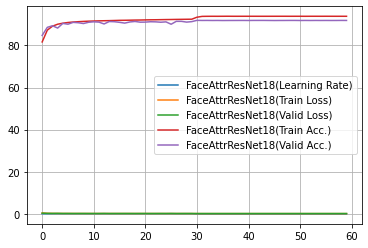

In [18]:
# config.epoch = 1
start_time = time.time()
model = create_model(device)
dataloaders, attribute_names  = load_dataloaders()
criterion = nn.CrossEntropyLoss().to(device)
# print(criterion)
optimizer = torch.optim.SGD(model.parameters(), config.lr,
                            momentum=config.momentum,
                            weight_decay=config.weight_decay)
# print(optimizer)
if config.evaluate:
    best_prec1, _, _ = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.bestmodel_fname)
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print_attribute_acc(top1, attribute_names)
else:
    best_prec1, start_epoch, logger = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.ckp_resume)
    run_name, run_time = get_run_name_time(model, criterion, optimizer)
    trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name)
end_time = time.time()
time_taken = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))
print(f"total time taken: {time_taken}")

In [19]:
# reset_gpu_cache(model,optimizer,criterion, device)

In [20]:
if not config.evaluate:
    config.evaluate = True
    model = create_model(device)
    dataloaders, attribute_names = load_dataloaders()
    criterion = nn.CrossEntropyLoss().to(device)
    best_prec1, _, _ = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.bestmodel_fname)# config.bestmodel_fname config.checkpoint_fname

    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print_attribute_acc(top1, attribute_names)

=> creating model 'FaceAttrResNet'
Dataset sizes: {'test': 19962}
Class Labels: 40
=> resuming model: checkpoints\checkpoint.pth.tar
=> loading checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/156 [00:00<?, ?it/s]

=> loaded checkpoint 'checkpoints\checkpoint.pth.tar' (epoch 60)


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.86it/s]

=> Best test accuracy: 91.46991782437324, Model val acc: 91.88931393526624
5_o_Clock_Shadow: 94.76505358273371
Arched_Eyebrows: 84.35026546623888
Attractive: 82.76725778827183
Bags_Under_Eyes: 85.52750221606355
Bald: 99.0632201212822
Bangs: 95.9673379107499
Big_Lips: 72.29235544864956
Big_Nose: 84.44544635035449
Black_Hair: 89.89580201390821
Blond_Hair: 96.02244260967787
Blurry: 96.29295658011819
Brown_Hair: 89.52008816063876
Bushy_Eyebrows: 92.63600838770789
Chubby: 95.73189057301525
Double_Chin: 96.27291851083832
Eyeglasses: 99.64933373409478
Goatee: 97.53531707421224
Gray_Hair: 98.13645923516277
Heavy_Makeup: 91.78439032865447
High_Cheekbones: 87.61647126335693
Male: 98.29676385743264
Mouth_Slightly_Open: 94.05370200558184
Mustache: 96.99428915549896
Narrow_Eyes: 87.47620478221977
No_Beard: 96.23785188424779
Oval_Face: 76.21480810564609
Pale_Skin: 97.16962224488124
Pointy_Nose: 77.40206391074928
Receding_Hairline: 93.71806431533268
Rosy_Cheeks: 95.18585309264726
Sideburns: 97.835888

In [22]:
# Wait for notebook to save
%autosave 1
time.sleep(150)
%autosave 120

Autosaving every 120 seconds


In [44]:
def backup_everything(run_time, run_name, title):
    # backup checkpoints
    run_dir = os.path.join(config.BACKUP_DIR, run_name, run_time)
    create_dir_ifne(run_dir)
    fromDirectory = config.CHECKPOINT_DIR
    toDirectory = run_dir
    copy_tree(fromDirectory, toDirectory)
    # backup notebook html
    nb_name = title + '.ipynb'
    html_name = title + '.html'
    save_name = os.path.join(run_dir, html_name)
    !jupyter nbconvert --to html $nb_name
    !move $html_name $save_name
    
backup_everything(run_time, run_name, title)

[NbConvertApp] Converting notebook ai6126-project1-colab-v0.4.ipynb to html
[NbConvertApp] Writing 858977 bytes to ai6126-project1-colab-v0.4.html


        1 file(s) moved.


In [24]:
if config.auto_hibernate:
    os.system('shutdown -h')

0